## Data Cleaning
---

In [1]:
# import libraries
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from prophet.utilities import regressor_coefficients

In [2]:
# load dereg data
dereg=pd.read_csv('./data/dereg_edited.csv', skiprows=[1])

In [3]:
dereg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   data_series  252 non-null    object
 1   total_dereg  252 non-null    int64 
 2   cat_a        252 non-null    int64 
 3   cat_b        252 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 8.0+ KB


In [4]:
dereg["data_series"] = pd.to_datetime(dereg["data_series"]).map(pd.offsets.MonthBegin(1))

C:\Users\ng_li\anaconda3\lib\site-packages\pandas\core\base.py:880: FutureWarning: DateOffset.__call__ is deprecated and will be removed in a future version.  Use `offset + other` instead.
  new_values = map_f(values, mapper)


In [5]:
dereg.rename(columns={'cat_a':'dereg_cat_a', 'cat_b':'dereg_cat_b'}, inplace= True)

In [6]:
# create a mask to exclude 'data_series'
mask = ~(dereg.columns.isin(['data_series']))

In [7]:
cols_to_shift = dereg.columns[mask]

In [8]:
# shift all columns by 1 as we only know the info one month later
for col in cols_to_shift:
    new_col = col + '_lag'
    dereg[new_col] = dereg[col].shift(-1)

In [9]:
dereg_lag = dereg[:-1].drop(['total_dereg', 'dereg_cat_a','dereg_cat_b'], axis=1)

In [10]:
dereg_lag.tail()

,data_series,total_dereg_lag,dereg_cat_a_lag,dereg_cat_b_lag
246,2002-08-01,7320.0,3039.0,1589.0
247,2002-07-01,7181.0,3103.0,1598.0
248,2002-06-01,9542.0,3883.0,1910.0
249,2002-05-01,10858.0,5038.0,2344.0
250,2002-04-01,6453.0,2998.0,1480.0


In [11]:
# load new registered vehicles data
new_reg=pd.read_csv('./data/new_registration_edited.csv', skiprows=[1])

In [12]:
new_reg["data_series"] = pd.to_datetime(new_reg["data_series"]).map(pd.offsets.MonthBegin(1))

C:\Users\ng_li\anaconda3\lib\site-packages\pandas\core\base.py:880: FutureWarning: DateOffset.__call__ is deprecated and will be removed in a future version.  Use `offset + other` instead.
  new_values = map_f(values, mapper)


In [13]:
new_reg.head()

,data_series,total_reg,cat_a,cat_b
0,2023-02-01,3135,827,1041
1,2023-01-01,4398,1077,1272
2,2022-12-01,4371,1100,1165
3,2022-11-01,4209,1019,1296
4,2022-10-01,4372,1011,1303


In [14]:
new_reg.rename(columns={'cat_a':'reg_cat_a', 'cat_b':'reg_cat_b'}, inplace= True)

In [15]:
# create a mask to exclude 'data_series'
mask_new_reg = ~(new_reg.columns.isin(['data_series']))

In [16]:
cols_to_shift_new_reg = new_reg.columns[mask_new_reg]

In [17]:
# shift all columns by 1 as we only know the info one month later
for col in cols_to_shift_new_reg:
    new_col = col + '_lag'
    new_reg[new_col] = new_reg[col].shift(-1)

In [18]:
new_reg_lag = new_reg[:-1].drop(['total_reg', 'reg_cat_a','reg_cat_b'], axis=1)

In [19]:
new_reg_lag.tail()

,data_series,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag
246,2002-08-01,7711.0,2798.0,2249.0
247,2002-07-01,7115.0,2725.0,1879.0
248,2002-06-01,8099.0,3275.0,2021.0
249,2002-05-01,9049.0,4030.0,2375.0
250,2002-04-01,5668.0,2182.0,1899.0


In [20]:
# load COE data
coe=pd.read_csv('./data/coe_edited.csv')

In [21]:
coe["data_series"] = pd.to_datetime(coe["data_series"])

In [22]:
coe.head()

,data_series,total_quota,total_successful_bids,total_bids_received,cat_a_quota,cat_a_successful_bids,cat_a_bids_received,cat_a_quota_premium,cat_b_quota,cat_b_successful_bids,cat_b_bids_received,cat_b_quota_premium,cat_e_quota,cat_e_successful_bids,cat_e_bids_received,cat_e_quota_premium
0,2002-02-01,3939,3910,12160,1473,1450,4834,30003,651,651,2240,30660,805,804,2511,30688
1,2002-02-15,3991,3958,6210,1467,1466,2450,29997,649,647,965,30289,813,800,1391,30689
2,2002-03-01,3955,3943,11040,1491,1491,4267,31484,649,644,2229,32574,805,805,2255,31438
3,2002-03-15,3958,3839,7266,1468,1429,2800,33201,651,650,1052,34200,817,744,1594,34501
4,2002-04-01,3695,3615,7514,1110,1092,2484,37201,558,551,1119,39509,682,631,1797,41001


In [23]:
coe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   data_series            506 non-null    datetime64[ns]
 1   total_quota            506 non-null    object        
 2   total_successful_bids  506 non-null    object        
 3   total_bids_received    506 non-null    object        
 4   cat_a_quota            506 non-null    object        
 5   cat_a_successful_bids  506 non-null    object        
 6   cat_a_bids_received    506 non-null    object        
 7   cat_a_quota_premium    506 non-null    object        
 8   cat_b_quota            506 non-null    object        
 9   cat_b_successful_bids  506 non-null    object        
 10  cat_b_bids_received    506 non-null    object        
 11  cat_b_quota_premium    506 non-null    object        
 12  cat_e_quota            506 non-null    object        
 13  cat_e

In [24]:
coe.columns

Index(['data_series', 'total_quota', 'total_successful_bids',
       'total_bids_received', 'cat_a_quota', 'cat_a_successful_bids',
       'cat_a_bids_received', 'cat_a_quota_premium', 'cat_b_quota',
       'cat_b_successful_bids', 'cat_b_bids_received', 'cat_b_quota_premium',
       'cat_e_quota', 'cat_e_successful_bids', 'cat_e_bids_received',
       'cat_e_quota_premium'],
      dtype='object')

In [25]:
# create a mask to exclude info that we will know before COE bidding
mask_coe = ~(coe.columns.isin(['data_series', 'total_quota', 'cat_a_quota', 'cat_b_quota', 'cat_e_quota']))

In [26]:
cols_to_shift_coe = coe.columns[mask_coe]

In [27]:
# shift all columns by 1 as we only know the info one month later
for col in cols_to_shift_coe:
    new_col = col + '_lag'
    coe[new_col] = coe[col].shift(1)

In [28]:
coe.head()

,data_series,total_quota,total_successful_bids,total_bids_received,cat_a_quota,cat_a_successful_bids,cat_a_bids_received,cat_a_quota_premium,cat_b_quota,cat_b_successful_bids,...,total_bids_received_lag,cat_a_successful_bids_lag,cat_a_bids_received_lag,cat_a_quota_premium_lag,cat_b_successful_bids_lag,cat_b_bids_received_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag
0,2002-02-01,3939,3910,12160,1473,1450,4834,30003,651,651,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2002-02-15,3991,3958,6210,1467,1466,2450,29997,649,647,...,12160,1450,4834,30003,651,2240,30660,804,2511,30688
2,2002-03-01,3955,3943,11040,1491,1491,4267,31484,649,644,...,6210,1466,2450,29997,647,965,30289,800,1391,30689
3,2002-03-15,3958,3839,7266,1468,1429,2800,33201,651,650,...,11040,1491,4267,31484,644,2229,32574,805,2255,31438
4,2002-04-01,3695,3615,7514,1110,1092,2484,37201,558,551,...,7266,1429,2800,33201,650,1052,34200,744,1594,34501


In [29]:
coe = coe[1:]

In [30]:
mask_replace = ~(coe.columns.isin(['data_series']))

In [31]:
cols_to_replace_coe = coe.columns[mask_replace]

In [32]:
# there are three months where there was no COE bidding due to covd
# to replace '-' with 0 for those months
for col in cols_to_replace_coe:
    coe.replace(to_replace='-', value=0, inplace=True, regex=False)

In [33]:
# change the data type to int
for col in coe.iloc[:,1:]:
    coe[col] = coe[col].astype(int)

In [34]:
coe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 1 to 505
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   data_series                505 non-null    datetime64[ns]
 1   total_quota                505 non-null    int32         
 2   total_successful_bids      505 non-null    int32         
 3   total_bids_received        505 non-null    int32         
 4   cat_a_quota                505 non-null    int32         
 5   cat_a_successful_bids      505 non-null    int32         
 6   cat_a_bids_received        505 non-null    int32         
 7   cat_a_quota_premium        505 non-null    int32         
 8   cat_b_quota                505 non-null    int32         
 9   cat_b_successful_bids      505 non-null    int32         
 10  cat_b_bids_received        505 non-null    int32         
 11  cat_b_quota_premium        505 non-null    int32         
 12  cat_e_qu

In [35]:
# load vehicle population data
vehicle_pop=pd.read_csv('./data/vehicle_population_edited.csv', skiprows=[1])

In [36]:
vehicle_pop["data_series"] = pd.to_datetime(vehicle_pop["data_series"]).map(pd.offsets.MonthBegin(1))

C:\Users\ng_li\anaconda3\lib\site-packages\pandas\core\base.py:880: FutureWarning: DateOffset.__call__ is deprecated and will be removed in a future version.  Use `offset + other` instead.
  new_values = map_f(values, mapper)


In [37]:
vehicle_pop.head()

,data_series,total_veh_pop,total_cars,total_private_hire_cars
0,2023-02-01,995905,580004,73318
1,2023-01-01,995746,580332,72632
2,2022-12-01,994820,580543,71649
3,2022-11-01,994790,581297,71030
4,2022-10-01,994021,581488,70311


In [38]:
# create a mask to exclude 'data_series'
mask_veh_pop = ~(vehicle_pop.columns.isin(['data_series']))

In [39]:
cols_to_shift_veh_pop = vehicle_pop.columns[mask_veh_pop]

In [40]:
# shift all columns by 1 as we only know the info one month later
for col in cols_to_shift_veh_pop:
    new_col = col + '_lag'
    vehicle_pop[new_col] = vehicle_pop[col].shift(-1)

In [41]:
vehicle_pop_lag = vehicle_pop[:-1].drop(['total_veh_pop', 'total_cars','total_private_hire_cars'], axis=1)

In [42]:
vehicle_pop_lag.tail()

,data_series,total_veh_pop_lag,total_cars_lag,total_private_hire_cars_lag
246,2002-08-01,705059.0,398500.0,8481.0
247,2002-07-01,704668.0,398037.0,8533.0
248,2002-06-01,704734.0,398050.0,8611.0
249,2002-05-01,706177.0,398487.0,8666.0
250,2002-04-01,707986.0,399335.0,8808.0


In [43]:
coe.columns

Index(['data_series', 'total_quota', 'total_successful_bids',
       'total_bids_received', 'cat_a_quota', 'cat_a_successful_bids',
       'cat_a_bids_received', 'cat_a_quota_premium', 'cat_b_quota',
       'cat_b_successful_bids', 'cat_b_bids_received', 'cat_b_quota_premium',
       'cat_e_quota', 'cat_e_successful_bids', 'cat_e_bids_received',
       'cat_e_quota_premium', 'total_successful_bids_lag',
       'total_bids_received_lag', 'cat_a_successful_bids_lag',
       'cat_a_bids_received_lag', 'cat_a_quota_premium_lag',
       'cat_b_successful_bids_lag', 'cat_b_bids_received_lag',
       'cat_b_quota_premium_lag', 'cat_e_successful_bids_lag',
       'cat_e_bids_received_lag', 'cat_e_quota_premium_lag'],
      dtype='object')

In [44]:
pd.set_option('display.max_columns', None)

In [45]:
# merge all datasets into one using date
df = coe.merge(vehicle_pop_lag, how='left', on='data_series').merge(new_reg_lag, how='left', on='data_series')\
.merge(dereg_lag,how='left', on='data_series')

In [46]:
df.columns

Index(['data_series', 'total_quota', 'total_successful_bids',
       'total_bids_received', 'cat_a_quota', 'cat_a_successful_bids',
       'cat_a_bids_received', 'cat_a_quota_premium', 'cat_b_quota',
       'cat_b_successful_bids', 'cat_b_bids_received', 'cat_b_quota_premium',
       'cat_e_quota', 'cat_e_successful_bids', 'cat_e_bids_received',
       'cat_e_quota_premium', 'total_successful_bids_lag',
       'total_bids_received_lag', 'cat_a_successful_bids_lag',
       'cat_a_bids_received_lag', 'cat_a_quota_premium_lag',
       'cat_b_successful_bids_lag', 'cat_b_bids_received_lag',
       'cat_b_quota_premium_lag', 'cat_e_successful_bids_lag',
       'cat_e_bids_received_lag', 'cat_e_quota_premium_lag',
       'total_veh_pop_lag', 'total_cars_lag', 'total_private_hire_cars_lag',
       'total_reg_lag', 'reg_cat_a_lag', 'reg_cat_b_lag', 'total_dereg_lag',
       'dereg_cat_a_lag', 'dereg_cat_b_lag'],
      dtype='object')

## Cat A COE
---

### Cat A Base Model

In [47]:
df_a = df[['data_series', 'cat_a_quota_premium', 'total_quota','cat_a_quota',
          'cat_b_quota','cat_e_quota', 'total_successful_bids_lag',
       'total_bids_received_lag', 'cat_a_successful_bids_lag',
       'cat_a_bids_received_lag', 'cat_a_quota_premium_lag',
       'cat_b_successful_bids_lag', 'cat_b_bids_received_lag',
       'cat_b_quota_premium_lag', 'cat_e_successful_bids_lag',
       'cat_e_bids_received_lag', 'cat_e_quota_premium_lag',
       'total_veh_pop_lag', 'total_cars_lag', 'total_private_hire_cars_lag',
       'total_reg_lag', 'reg_cat_a_lag', 'reg_cat_b_lag', 'total_dereg_lag',
       'dereg_cat_a_lag', 'dereg_cat_b_lag']]

In [48]:
df_a.isnull().sum()

data_series                      0
cat_a_quota_premium              0
total_quota                      0
cat_a_quota                      0
cat_b_quota                      0
cat_e_quota                      0
total_successful_bids_lag        0
total_bids_received_lag          0
cat_a_successful_bids_lag        0
cat_a_bids_received_lag          0
cat_a_quota_premium_lag          0
cat_b_successful_bids_lag        0
cat_b_bids_received_lag          0
cat_b_quota_premium_lag          0
cat_e_successful_bids_lag        0
cat_e_bids_received_lag          0
cat_e_quota_premium_lag          0
total_veh_pop_lag              254
total_cars_lag                 254
total_private_hire_cars_lag    254
total_reg_lag                  254
reg_cat_a_lag                  254
reg_cat_b_lag                  254
total_dereg_lag                254
dereg_cat_a_lag                254
dereg_cat_b_lag                254
dtype: int64

In [49]:
# null values are due to once a month info, hence doing a forward fill
df_a.fillna(method='ffill', inplace=True)

C:\Users\ng_li\AppData\Local\Temp\ipykernel_17012\2155006767.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_a.fillna(method='ffill', inplace=True)


In [50]:
# drop NA
df_a.dropna(inplace=True)

C:\Users\ng_li\AppData\Local\Temp\ipykernel_17012\1709374988.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_a.dropna(inplace=True)


In [51]:
df_a.isnull().sum()

data_series                    0
cat_a_quota_premium            0
total_quota                    0
cat_a_quota                    0
cat_b_quota                    0
cat_e_quota                    0
total_successful_bids_lag      0
total_bids_received_lag        0
cat_a_successful_bids_lag      0
cat_a_bids_received_lag        0
cat_a_quota_premium_lag        0
cat_b_successful_bids_lag      0
cat_b_bids_received_lag        0
cat_b_quota_premium_lag        0
cat_e_successful_bids_lag      0
cat_e_bids_received_lag        0
cat_e_quota_premium_lag        0
total_veh_pop_lag              0
total_cars_lag                 0
total_private_hire_cars_lag    0
total_reg_lag                  0
reg_cat_a_lag                  0
reg_cat_b_lag                  0
total_dereg_lag                0
dereg_cat_a_lag                0
dereg_cat_b_lag                0
dtype: int64

In [52]:
df_a.head()

,data_series,cat_a_quota_premium,total_quota,cat_a_quota,cat_b_quota,cat_e_quota,total_successful_bids_lag,total_bids_received_lag,cat_a_successful_bids_lag,cat_a_bids_received_lag,cat_a_quota_premium_lag,cat_b_successful_bids_lag,cat_b_bids_received_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag,total_veh_pop_lag,total_cars_lag,total_private_hire_cars_lag,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag,total_dereg_lag,dereg_cat_a_lag,dereg_cat_b_lag
3,2002-04-01,37201,3695,1110,558,682,3839,7266,1429,2800,33201,650,1052,34200,744,1594,34501,707986.0,399335.0,8808.0,5668.0,2182.0,1899.0,6453.0,2998.0,1480.0
4,2002-04-15,36000,3800,1149,553,754,3615,7514,1092,2484,37201,551,1119,39509,631,1797,41001,707986.0,399335.0,8808.0,5668.0,2182.0,1899.0,6453.0,2998.0,1480.0
5,2002-05-01,35000,3990,1128,560,960,3781,6298,1148,1890,36000,553,1104,42101,753,1407,42043,706177.0,398487.0,8666.0,9049.0,4030.0,2375.0,10858.0,5038.0,2344.0
6,2002-05-15,33401,3928,1111,552,910,3840,6504,1127,1705,35000,518,1043,40001,930,1880,40001,706177.0,398487.0,8666.0,9049.0,4030.0,2375.0,10858.0,5038.0,2344.0
7,2002-06-01,33009,4060,1111,595,939,3837,5908,1080,1320,33401,541,894,38001,877,1835,38399,704734.0,398050.0,8611.0,8099.0,3275.0,2021.0,9542.0,3883.0,1910.0


In [53]:
# as there weere three months with no coe bidding, to load them as 'holidays' in FBprophet
holidays = pd.read_csv('./data/holidays_1.csv')

In [54]:
holidays

,holiday,ds
0,covid,2020-04-01
1,covid,2020-04-15
2,covid,2020-05-01
3,covid,2020-05-15
4,covid,2020-06-01
5,covid,2020-06-15


In [55]:
m = Prophet(holidays=holidays)

In [56]:
# rename date and y columns
df_a.rename(columns={'data_series': 'ds', 'cat_a_quota_premium': 'y'}, inplace=True)

C:\Users\ng_li\AppData\Local\Temp\ipykernel_17012\2402029783.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_a.rename(columns={'data_series': 'ds', 'cat_a_quota_premium': 'y'}, inplace=True)


In [57]:
df_a.head()

,ds,y,total_quota,cat_a_quota,cat_b_quota,cat_e_quota,total_successful_bids_lag,total_bids_received_lag,cat_a_successful_bids_lag,cat_a_bids_received_lag,cat_a_quota_premium_lag,cat_b_successful_bids_lag,cat_b_bids_received_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag,total_veh_pop_lag,total_cars_lag,total_private_hire_cars_lag,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag,total_dereg_lag,dereg_cat_a_lag,dereg_cat_b_lag
3,2002-04-01,37201,3695,1110,558,682,3839,7266,1429,2800,33201,650,1052,34200,744,1594,34501,707986.0,399335.0,8808.0,5668.0,2182.0,1899.0,6453.0,2998.0,1480.0
4,2002-04-15,36000,3800,1149,553,754,3615,7514,1092,2484,37201,551,1119,39509,631,1797,41001,707986.0,399335.0,8808.0,5668.0,2182.0,1899.0,6453.0,2998.0,1480.0
5,2002-05-01,35000,3990,1128,560,960,3781,6298,1148,1890,36000,553,1104,42101,753,1407,42043,706177.0,398487.0,8666.0,9049.0,4030.0,2375.0,10858.0,5038.0,2344.0
6,2002-05-15,33401,3928,1111,552,910,3840,6504,1127,1705,35000,518,1043,40001,930,1880,40001,706177.0,398487.0,8666.0,9049.0,4030.0,2375.0,10858.0,5038.0,2344.0
7,2002-06-01,33009,4060,1111,595,939,3837,5908,1080,1320,33401,541,894,38001,877,1835,38399,704734.0,398050.0,8611.0,8099.0,3275.0,2021.0,9542.0,3883.0,1910.0


In [58]:
df_a.shape

(502, 26)

In [59]:
# split the data into train and test sets
train_a = df_a.iloc[0:402]

test_a = df_a.iloc[402:]

In [60]:
train_a.tail()

,ds,y,total_quota,cat_a_quota,cat_b_quota,cat_e_quota,total_successful_bids_lag,total_bids_received_lag,cat_a_successful_bids_lag,cat_a_bids_received_lag,cat_a_quota_premium_lag,cat_b_successful_bids_lag,cat_b_bids_received_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag,total_veh_pop_lag,total_cars_lag,total_private_hire_cars_lag,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag,total_dereg_lag,dereg_cat_a_lag,dereg_cat_b_lag
400,2018-10-15,25556,4655,1674,1273,539,4598,6673,1665,2059,28457,1241,1886,31301,543,1066,32552,956287.0,550117.0,66998.0,8533.0,2721.0,3208.0,9543.0,4001.0,2749.0
401,2018-11-01,28199,5094,1819,1265,557,4634,6117,1672,1811,25556,1267,1856,31302,527,779,32900,955956.0,550423.0,66410.0,8843.0,2887.0,3280.0,9174.0,3886.0,2556.0
402,2018-11-15,25000,5045,1818,1241,552,4999,7856,1757,2849,28199,1262,2142,32302,544,862,32000,955956.0,550423.0,66410.0,8843.0,2887.0,3280.0,9174.0,3886.0,2556.0
403,2018-12-01,23568,5119,1878,1239,552,4944,6950,1744,2231,25000,1234,1786,31101,546,930,30959,956106.0,551018.0,66273.0,9876.0,3018.0,3719.0,9726.0,3656.0,2634.0
404,2018-12-15,25501,5125,1890,1243,545,5095,6950,1878,2177,23568,1230,1780,31001,546,1021,30851,956106.0,551018.0,66273.0,9876.0,3018.0,3719.0,9726.0,3656.0,2634.0


In [61]:
test_a.head()

,ds,y,total_quota,cat_a_quota,cat_b_quota,cat_e_quota,total_successful_bids_lag,total_bids_received_lag,cat_a_successful_bids_lag,cat_a_bids_received_lag,cat_a_quota_premium_lag,cat_b_successful_bids_lag,cat_b_bids_received_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag,total_veh_pop_lag,total_cars_lag,total_private_hire_cars_lag,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag,total_dereg_lag,dereg_cat_a_lag,dereg_cat_b_lag
405,2019-01-01,25920,5048,1815,1245,546,5099,7189,1887,2729,25501,1235,1804,31001,545,778,31809,956428.0,551407.0,66079.0,9923.0,3238.0,3523.0,9601.0,3872.0,2688.0
406,2019-01-15,26170,5050,1818,1244,540,4997,7169,1804,2707,25920,1242,1818,32200,540,776,32909,956428.0,551407.0,66079.0,9923.0,3238.0,3523.0,9601.0,3872.0,2688.0
407,2019-02-01,25689,4427,1662,1202,403,5024,7790,1818,2864,26170,1230,2119,33989,530,797,33689,957006.0,551575.0,66480.0,9922.0,2930.0,3714.0,9344.0,3465.0,2661.0
408,2019-02-15,26301,4403,1650,1214,407,4372,6483,1653,2371,25689,1169,1937,34509,392,545,35310,957006.0,551575.0,66480.0,9922.0,2930.0,3714.0,9344.0,3465.0,2661.0
409,2019-03-01,26309,4431,1659,1233,408,4393,6445,1650,2261,26301,1213,1993,35403,407,658,36667,959468.0,552763.0,67571.0,11782.0,4111.0,4138.0,9320.0,3438.0,2534.0


In [62]:
df_a.iloc[:,2:]

,total_quota,cat_a_quota,cat_b_quota,cat_e_quota,total_successful_bids_lag,total_bids_received_lag,cat_a_successful_bids_lag,cat_a_bids_received_lag,cat_a_quota_premium_lag,cat_b_successful_bids_lag,cat_b_bids_received_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag,total_veh_pop_lag,total_cars_lag,total_private_hire_cars_lag,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag,total_dereg_lag,dereg_cat_a_lag,dereg_cat_b_lag
3,3695,1110,558,682,3839,7266,1429,2800,33201,650,1052,34200,744,1594,34501,707986.0,399335.0,8808.0,5668.0,2182.0,1899.0,6453.0,2998.0,1480.0
4,3800,1149,553,754,3615,7514,1092,2484,37201,551,1119,39509,631,1797,41001,707986.0,399335.0,8808.0,5668.0,2182.0,1899.0,6453.0,2998.0,1480.0
5,3990,1128,560,960,3781,6298,1148,1890,36000,553,1104,42101,753,1407,42043,706177.0,398487.0,8666.0,9049.0,4030.0,2375.0,10858.0,5038.0,2344.0
6,3928,1111,552,910,3840,6504,1127,1705,35000,518,1043,40001,930,1880,40001,706177.0,398487.0,8666.0,9049.0,4030.0,2375.0,10858.0,5038.0,2344.0
7,4060,1111,595,939,3837,5908,1080,1320,33401,541,894,38001,877,1835,38399,704734.0,398050.0,8611.0,8099.0,3275.0,2021.0,9542.0,3883.0,1910.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,1562,473,409,146,1533,2112,454,616,88503,426,568,105501,148,266,110524,994790.0,581297.0,71030.0,4209.0,1019.0,1296.0,3440.0,1028.0,779.0
501,1533,462,410,146,1545,2249,472,618,88007,409,564,108006,143,273,109600,994820.0,580543.0,71649.0,4371.0,1100.0,1165.0,4341.0,1424.0,990.0
502,1539,459,408,149,1517,2282,459,649,80000,410,487,102002,146,285,107889,994820.0,580543.0,71649.0,4371.0,1100.0,1165.0,4341.0,1424.0,990.0
503,1589,509,430,129,1510,2143,456,627,86000,402,514,105459,147,248,107000,995746.0,580332.0,72632.0,4398.0,1077.0,1272.0,3472.0,857.0,742.0


In [63]:
# add the other columns as regressor
for col in df_a.iloc[:,2:]:
    m.add_regressor(col, standardize = True)

In [64]:
# fit the model using the training dataset
m.fit(train_a)

22:51:05 - cmdstanpy - INFO - Chain [1] start processing
22:51:05 - cmdstanpy - INFO - Chain [1] done processing


In [65]:
# create a future dataframe for prediction
future_a = m.make_future_dataframe(periods=100)

In [66]:
future_a.shape

(502, 1)

In [67]:
df_a.tail()

,ds,y,total_quota,cat_a_quota,cat_b_quota,cat_e_quota,total_successful_bids_lag,total_bids_received_lag,cat_a_successful_bids_lag,cat_a_bids_received_lag,cat_a_quota_premium_lag,cat_b_successful_bids_lag,cat_b_bids_received_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag,total_veh_pop_lag,total_cars_lag,total_private_hire_cars_lag,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag,total_dereg_lag,dereg_cat_a_lag,dereg_cat_b_lag
500,2022-12-15,88007,1562,473,409,146,1533,2112,454,616,88503,426,568,105501,148,266,110524,994790.0,581297.0,71030.0,4209.0,1019.0,1296.0,3440.0,1028.0,779.0
501,2023-01-01,80000,1533,462,410,146,1545,2249,472,618,88007,409,564,108006,143,273,109600,994820.0,580543.0,71649.0,4371.0,1100.0,1165.0,4341.0,1424.0,990.0
502,2023-01-15,86000,1539,459,408,149,1517,2282,459,649,80000,410,487,102002,146,285,107889,994820.0,580543.0,71649.0,4371.0,1100.0,1165.0,4341.0,1424.0,990.0
503,2023-02-01,86000,1589,509,430,129,1510,2143,456,627,86000,402,514,105459,147,248,107000,995746.0,580332.0,72632.0,4398.0,1077.0,1272.0,3472.0,857.0,742.0
504,2023-02-15,86556,1602,508,436,132,1572,2174,497,663,86000,430,580,105524,126,229,105002,995746.0,580332.0,72632.0,4398.0,1077.0,1272.0,3472.0,857.0,742.0


In [68]:
df_a.columns

Index(['ds', 'y', 'total_quota', 'cat_a_quota', 'cat_b_quota', 'cat_e_quota',
       'total_successful_bids_lag', 'total_bids_received_lag',
       'cat_a_successful_bids_lag', 'cat_a_bids_received_lag',
       'cat_a_quota_premium_lag', 'cat_b_successful_bids_lag',
       'cat_b_bids_received_lag', 'cat_b_quota_premium_lag',
       'cat_e_successful_bids_lag', 'cat_e_bids_received_lag',
       'cat_e_quota_premium_lag', 'total_veh_pop_lag', 'total_cars_lag',
       'total_private_hire_cars_lag', 'total_reg_lag', 'reg_cat_a_lag',
       'reg_cat_b_lag', 'total_dereg_lag', 'dereg_cat_a_lag',
       'dereg_cat_b_lag'],
      dtype='object')

In [69]:
# add regressor in future dataframe
future_a=pd.concat((future_a, df_a[['total_quota','cat_a_quota',
          'cat_b_quota','cat_e_quota', 'total_successful_bids_lag',
       'total_bids_received_lag', 'cat_a_successful_bids_lag',
       'cat_a_bids_received_lag', 'cat_a_quota_premium_lag',
       'cat_b_successful_bids_lag', 'cat_b_bids_received_lag',
       'cat_b_quota_premium_lag', 'cat_e_successful_bids_lag',
       'cat_e_bids_received_lag', 'cat_e_quota_premium_lag',
       'total_veh_pop_lag', 'total_cars_lag', 'total_private_hire_cars_lag',
       'total_reg_lag', 'reg_cat_a_lag', 'reg_cat_b_lag', 'total_dereg_lag',
       'dereg_cat_a_lag', 'dereg_cat_b_lag']]),axis=1)

In [70]:
future_a.head()

,ds,total_quota,cat_a_quota,cat_b_quota,cat_e_quota,total_successful_bids_lag,total_bids_received_lag,cat_a_successful_bids_lag,cat_a_bids_received_lag,cat_a_quota_premium_lag,cat_b_successful_bids_lag,cat_b_bids_received_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag,total_veh_pop_lag,total_cars_lag,total_private_hire_cars_lag,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag,total_dereg_lag,dereg_cat_a_lag,dereg_cat_b_lag
0,2002-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2002-04-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2002-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2002-05-15,3695.0,1110.0,558.0,682.0,3839.0,7266.0,1429.0,2800.0,33201.0,650.0,1052.0,34200.0,744.0,1594.0,34501.0,707986.0,399335.0,8808.0,5668.0,2182.0,1899.0,6453.0,2998.0,1480.0
4,2002-06-01,3800.0,1149.0,553.0,754.0,3615.0,7514.0,1092.0,2484.0,37201.0,551.0,1119.0,39509.0,631.0,1797.0,41001.0,707986.0,399335.0,8808.0,5668.0,2182.0,1899.0,6453.0,2998.0,1480.0


In [71]:
# check for null
future_a.isnull().sum()

ds                             3
total_quota                    3
cat_a_quota                    3
cat_b_quota                    3
cat_e_quota                    3
total_successful_bids_lag      3
total_bids_received_lag        3
cat_a_successful_bids_lag      3
cat_a_bids_received_lag        3
cat_a_quota_premium_lag        3
cat_b_successful_bids_lag      3
cat_b_bids_received_lag        3
cat_b_quota_premium_lag        3
cat_e_successful_bids_lag      3
cat_e_bids_received_lag        3
cat_e_quota_premium_lag        3
total_veh_pop_lag              3
total_cars_lag                 3
total_private_hire_cars_lag    3
total_reg_lag                  3
reg_cat_a_lag                  3
reg_cat_b_lag                  3
total_dereg_lag                3
dereg_cat_a_lag                3
dereg_cat_b_lag                3
dtype: int64

In [72]:
# drop na as there are only three null rows
future_a.dropna(inplace=True)

In [73]:
# forecast the future dataframe values
forecast_a = m.predict(future_a)

In [74]:
# add yhat to df_a (original dataframe)
final_df_a = pd.concat((forecast_a['yhat'],df_a), axis=1)

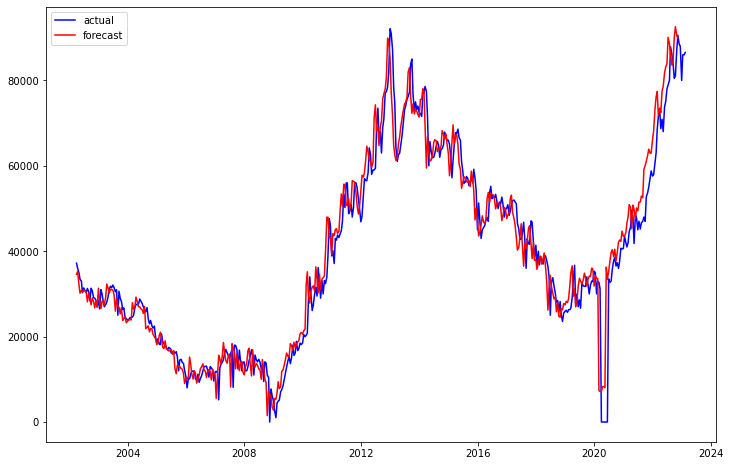

In [75]:
# plot actual vs forecast
plt.figure(figsize=(12,8))
plt.plot(final_df_a['ds'],final_df_a['y'], color='blue', label = 'actual')
plt.plot(final_df_a['ds'],final_df_a['yhat'], color='red', label = 'forecast')
plt.legend()

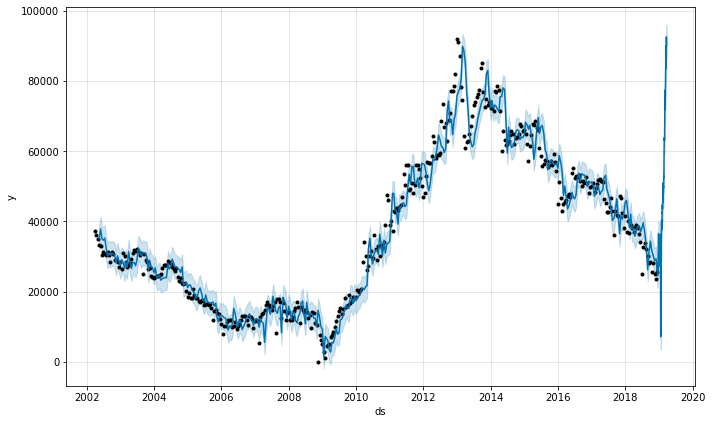

In [76]:
fig_a = m.plot(forecast_a)
# ax_a = fig_a.gca()
# ax_a.plot(test_a["ds"], test_a["y"], 'r.')

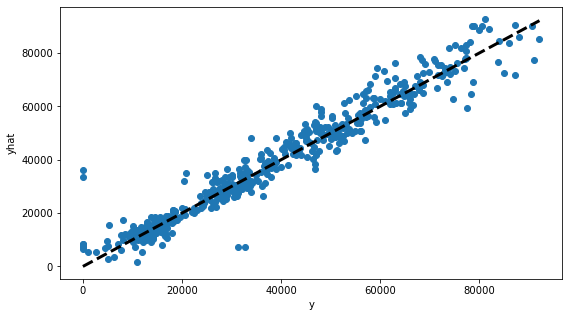

In [77]:
# plot y against yhat
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
ax.scatter(final_df_a['y'], final_df_a['yhat'])
ax.plot([final_df_a['y'].min(), final_df_a['y'].max()], [final_df_a['y'].min(), final_df_a['y'].max()], 'k--', lw=3)
ax.set_xlabel('y')
ax.set_ylabel('yhat')
plt.show()

The model doesn't seem to predict very well when the Cat A COE premium is more than 70,000, which is for the most part after 2022.
This is expected as there are many external gloabl factors affecting Singapore's economy after year 2022.

### Cat A Base Model - RMSE
---

In [78]:
# cross validation
df_cv = cross_validation(m, initial='3650 days', period='30 days', horizon = '1825 days', parallel="processes")
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-05-01,64533.348894,61910.704150,67511.655632,62600,2012-04-25
1,2012-05-15,64025.262861,61318.199879,66625.047791,58001,2012-04-25
2,2012-06-01,61532.030738,58857.687700,64295.799815,59003,2012-04-25
3,2012-06-15,61060.942569,58306.925262,63983.187204,59004,2012-04-25
4,2012-07-01,61008.126203,58299.501771,63670.279859,59421,2012-04-25


In [79]:
# model performance metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,181 days,3.791583e+07,6157.582848,4876.291381,0.065942,0.057306,0.065597,0.416667
1,190 days,3.841901e+07,6198.306957,4926.399526,0.066538,0.057906,0.066242,0.408730
2,191 days,3.968597e+07,6299.680196,4963.391663,0.066825,0.057538,0.066602,0.412698
3,192 days,3.935630e+07,6273.459614,4920.690329,0.066234,0.057306,0.065998,0.420635
4,193 days,3.918214e+07,6259.564166,4918.260136,0.066231,0.057538,0.065967,0.417989


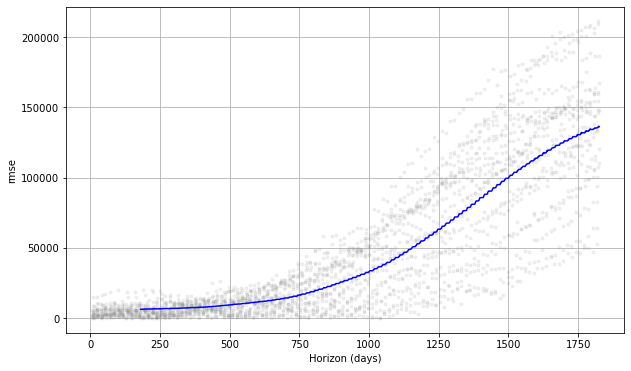

In [80]:
# visualize the performance metrics
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [81]:
metric_a = forecast_a.set_index('ds')[['yhat']].join(df_a.set_index('ds').y).reset_index()

In [82]:
metric_a.tail()

,ds,yhat,y
494,2019-03-21,84356.740861,NaN
495,2019-03-22,90198.861096,NaN
496,2019-03-23,92583.035529,NaN
497,2019-03-24,90453.034038,NaN
498,2019-03-25,89949.412384,NaN


In [83]:
#drop null as we only want to look at the actual values.
metric_a.dropna(inplace=True)

In [84]:
metric_a.tail()

,ds,yhat,y
429,2019-01-15,31851.723606,26170.0
446,2019-02-01,40472.456405,25689.0
460,2019-02-15,45302.488948,26301.0
474,2019-03-01,63904.542654,26309.0
488,2019-03-15,83096.674001,26659.0


In [85]:
# calculate r2
r2_score(metric_a.y, metric_a.yhat)

0.9130589403453935

In [86]:
# calculate rmse
mean_squared_error(metric_a.y, metric_a.yhat, squared = False)

6264.724170702964

In [87]:
# calculate mape
mean_absolute_percentage_error(metric_a.y, metric_a.yhat)

18.206538807273944

### Cat A Remodel

<AxesSubplot:>

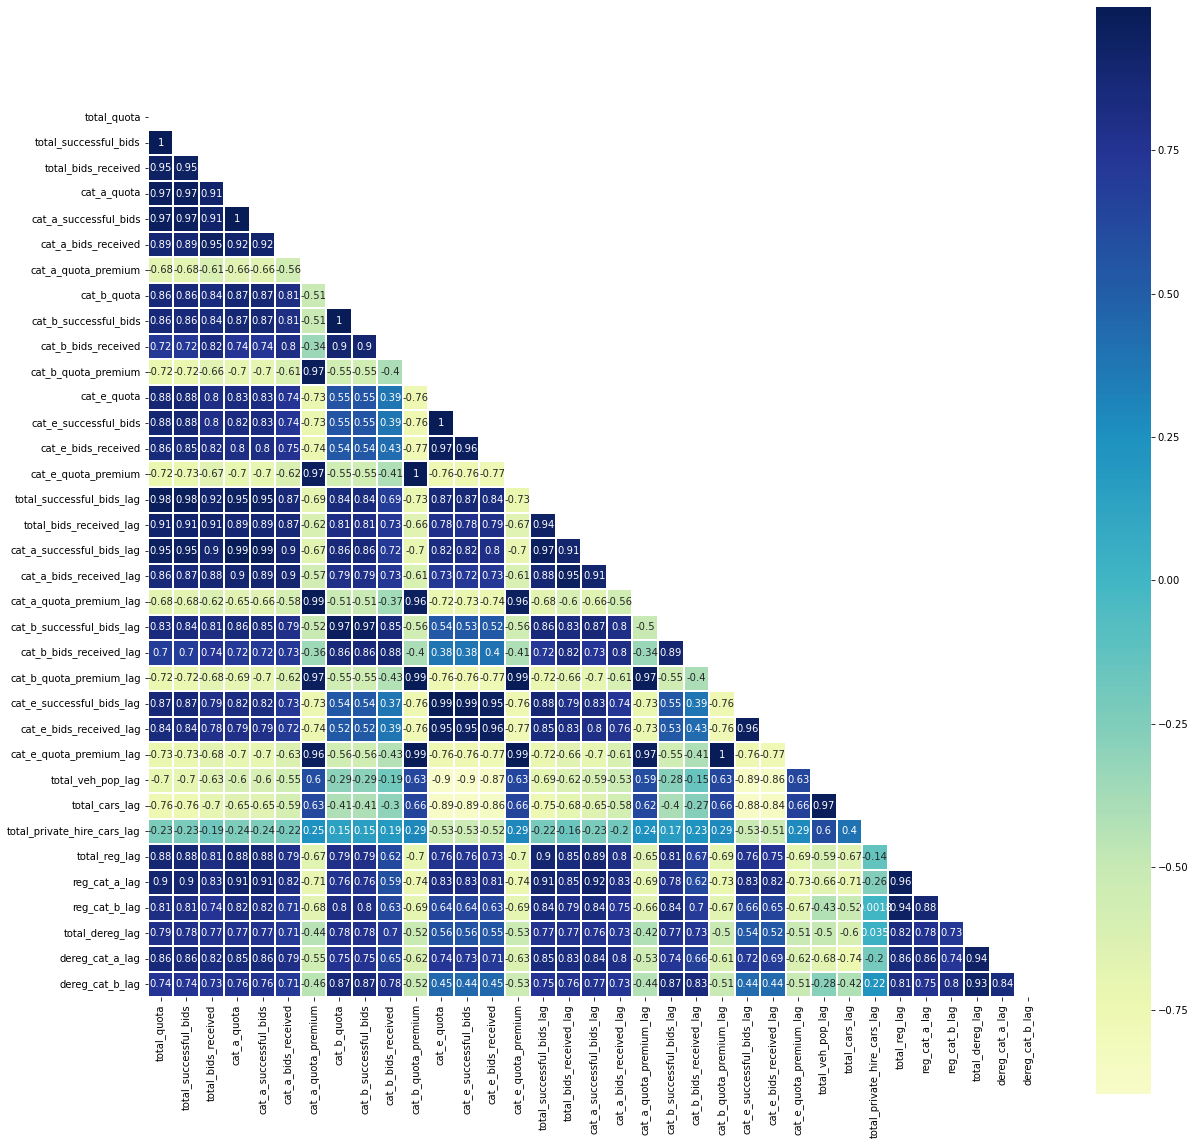

In [88]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap="YlGnBu", center=0, annot=True,
            square=True, linewidths=.2)

In [89]:
# select regressors where correlation is more than 60%
df_a = df[['data_series', 'cat_a_quota_premium', 'cat_a_quota','cat_e_quota','total_successful_bids_lag',
       'total_bids_received_lag', 'cat_a_successful_bids_lag','cat_b_quota_premium_lag', 'cat_e_successful_bids_lag',
       'cat_e_bids_received_lag', 'cat_e_quota_premium_lag',
       'total_veh_pop_lag', 'total_cars_lag', 'total_reg_lag', 'reg_cat_a_lag', 'reg_cat_b_lag'
          ]]

In [90]:
df_a.columns

Index(['data_series', 'cat_a_quota_premium', 'cat_a_quota', 'cat_e_quota',
       'total_successful_bids_lag', 'total_bids_received_lag',
       'cat_a_successful_bids_lag', 'cat_b_quota_premium_lag',
       'cat_e_successful_bids_lag', 'cat_e_bids_received_lag',
       'cat_e_quota_premium_lag', 'total_veh_pop_lag', 'total_cars_lag',
       'total_reg_lag', 'reg_cat_a_lag', 'reg_cat_b_lag'],
      dtype='object')

In [91]:
df_a.isnull().sum()

data_series                    0
cat_a_quota_premium            0
cat_a_quota                    0
cat_e_quota                    0
total_successful_bids_lag      0
total_bids_received_lag        0
cat_a_successful_bids_lag      0
cat_b_quota_premium_lag        0
cat_e_successful_bids_lag      0
cat_e_bids_received_lag        0
cat_e_quota_premium_lag        0
total_veh_pop_lag            254
total_cars_lag               254
total_reg_lag                254
reg_cat_a_lag                254
reg_cat_b_lag                254
dtype: int64

In [92]:
df_a.fillna(method='ffill', inplace=True)

C:\Users\ng_li\AppData\Local\Temp\ipykernel_17012\284968985.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_a.fillna(method='ffill', inplace=True)


In [93]:
df_a.dropna(inplace=True)

C:\Users\ng_li\AppData\Local\Temp\ipykernel_17012\1687054147.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_a.dropna(inplace=True)


In [94]:
df_a.isnull().sum()

data_series                  0
cat_a_quota_premium          0
cat_a_quota                  0
cat_e_quota                  0
total_successful_bids_lag    0
total_bids_received_lag      0
cat_a_successful_bids_lag    0
cat_b_quota_premium_lag      0
cat_e_successful_bids_lag    0
cat_e_bids_received_lag      0
cat_e_quota_premium_lag      0
total_veh_pop_lag            0
total_cars_lag               0
total_reg_lag                0
reg_cat_a_lag                0
reg_cat_b_lag                0
dtype: int64

In [95]:
df_a.rename(columns={'data_series': 'ds', 'cat_a_quota_premium': 'y'}, inplace=True)

C:\Users\ng_li\AppData\Local\Temp\ipykernel_17012\2773846055.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_a.rename(columns={'data_series': 'ds', 'cat_a_quota_premium': 'y'}, inplace=True)


In [96]:
df_a.head()

,ds,y,cat_a_quota,cat_e_quota,total_successful_bids_lag,total_bids_received_lag,cat_a_successful_bids_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag,total_veh_pop_lag,total_cars_lag,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag
3,2002-04-01,37201,1110,682,3839,7266,1429,34200,744,1594,34501,707986.0,399335.0,5668.0,2182.0,1899.0
4,2002-04-15,36000,1149,754,3615,7514,1092,39509,631,1797,41001,707986.0,399335.0,5668.0,2182.0,1899.0
5,2002-05-01,35000,1128,960,3781,6298,1148,42101,753,1407,42043,706177.0,398487.0,9049.0,4030.0,2375.0
6,2002-05-15,33401,1111,910,3840,6504,1127,40001,930,1880,40001,706177.0,398487.0,9049.0,4030.0,2375.0
7,2002-06-01,33009,1111,939,3837,5908,1080,38001,877,1835,38399,704734.0,398050.0,8099.0,3275.0,2021.0


In [97]:
df_a.shape

(502, 16)

In [98]:
train_a = df_a.iloc[0:402]

test_a = df_a.iloc[402:]

In [99]:
train_a.tail()

,ds,y,cat_a_quota,cat_e_quota,total_successful_bids_lag,total_bids_received_lag,cat_a_successful_bids_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag,total_veh_pop_lag,total_cars_lag,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag
400,2018-10-15,25556,1674,539,4598,6673,1665,31301,543,1066,32552,956287.0,550117.0,8533.0,2721.0,3208.0
401,2018-11-01,28199,1819,557,4634,6117,1672,31302,527,779,32900,955956.0,550423.0,8843.0,2887.0,3280.0
402,2018-11-15,25000,1818,552,4999,7856,1757,32302,544,862,32000,955956.0,550423.0,8843.0,2887.0,3280.0
403,2018-12-01,23568,1878,552,4944,6950,1744,31101,546,930,30959,956106.0,551018.0,9876.0,3018.0,3719.0
404,2018-12-15,25501,1890,545,5095,6950,1878,31001,546,1021,30851,956106.0,551018.0,9876.0,3018.0,3719.0


In [100]:
test_a.head()

,ds,y,cat_a_quota,cat_e_quota,total_successful_bids_lag,total_bids_received_lag,cat_a_successful_bids_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag,total_veh_pop_lag,total_cars_lag,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag
405,2019-01-01,25920,1815,546,5099,7189,1887,31001,545,778,31809,956428.0,551407.0,9923.0,3238.0,3523.0
406,2019-01-15,26170,1818,540,4997,7169,1804,32200,540,776,32909,956428.0,551407.0,9923.0,3238.0,3523.0
407,2019-02-01,25689,1662,403,5024,7790,1818,33989,530,797,33689,957006.0,551575.0,9922.0,2930.0,3714.0
408,2019-02-15,26301,1650,407,4372,6483,1653,34509,392,545,35310,957006.0,551575.0,9922.0,2930.0,3714.0
409,2019-03-01,26309,1659,408,4393,6445,1650,35403,407,658,36667,959468.0,552763.0,11782.0,4111.0,4138.0


In [101]:
df_a.head()

,ds,y,cat_a_quota,cat_e_quota,total_successful_bids_lag,total_bids_received_lag,cat_a_successful_bids_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag,total_veh_pop_lag,total_cars_lag,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag
3,2002-04-01,37201,1110,682,3839,7266,1429,34200,744,1594,34501,707986.0,399335.0,5668.0,2182.0,1899.0
4,2002-04-15,36000,1149,754,3615,7514,1092,39509,631,1797,41001,707986.0,399335.0,5668.0,2182.0,1899.0
5,2002-05-01,35000,1128,960,3781,6298,1148,42101,753,1407,42043,706177.0,398487.0,9049.0,4030.0,2375.0
6,2002-05-15,33401,1111,910,3840,6504,1127,40001,930,1880,40001,706177.0,398487.0,9049.0,4030.0,2375.0
7,2002-06-01,33009,1111,939,3837,5908,1080,38001,877,1835,38399,704734.0,398050.0,8099.0,3275.0,2021.0


In [102]:
cutoffs = pd.to_datetime(['2006-01-01','2008-02-15', '2010-04-01', '2010-10-15', '2011-05-01','2012-05-15',
                          '2014-01-01','2015-01-15','2017-01-15'
                         ])

In [103]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.25, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 2.5, 5.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(holidays=holidays,**params).fit(train_a)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='180 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

22:51:16 - cmdstanpy - INFO - Chain [1] start processing
22:51:16 - cmdstanpy - INFO - Chain [1] done processing
22:51:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
22:51:16 - cmdstanpy - INFO - Chain [1] start processing
22:51:17 - cmdstanpy - INFO - Chain [1] done processing
22:51:21 - cmdstanpy - INFO - Chain [1] start processing
22:51:22 - cmdstanpy - INFO - Chain [1] done processing
22:51:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
22:51:22 - cmdstanpy - INFO - Chain [1] start processing
22:51:22 - cmdstanpy - INFO - Chain [1] done processing
22:51:27 - cmdstanpy - INFO - Chain [1] start processing
22:51:27 - cmdstanpy - INFO - Chain [1] done processing
22:51:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newto

    changepoint_prior_scale  seasonality_prior_scale          rmse
0                     0.001                     0.01  21705.710863
1                     0.001                     0.10  21990.717049
2                     0.001                     1.00  21935.774815
3                     0.001                     2.50  21938.177069
4                     0.001                     5.00  21938.069674
5                     0.001                    10.00  21938.047461
6                     0.010                     0.01  22267.876785
7                     0.010                     0.10  22259.905478
8                     0.010                     1.00  22291.148871
9                     0.010                     2.50  22314.263495
10                    0.010                     5.00  22303.827846
11                    0.010                    10.00  22300.333738
12                    0.100                     0.01   8477.114309
13                    0.100                     0.10   8310.01

In [104]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1}


In [105]:
holidays

,holiday,ds
0,covid,2020-04-01
1,covid,2020-04-15
2,covid,2020-05-01
3,covid,2020-05-15
4,covid,2020-06-01
5,covid,2020-06-15


In [106]:
m = Prophet(holidays=holidays, changepoint_prior_scale=0.5, seasonality_prior_scale=0.1)

In [107]:
for col in df_a.iloc[:,2:]:
    m.add_regressor(col, standardize = True)

In [108]:
# Fit the model using the training dataset
m.fit(train_a)

22:53:59 - cmdstanpy - INFO - Chain [1] start processing
22:53:59 - cmdstanpy - INFO - Chain [1] done processing


In [109]:
# Create a future dataframe for prediction
future_a = m.make_future_dataframe(periods=100)

In [110]:
future_a.shape

(502, 1)

In [111]:
df_a.tail()

,ds,y,cat_a_quota,cat_e_quota,total_successful_bids_lag,total_bids_received_lag,cat_a_successful_bids_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag,total_veh_pop_lag,total_cars_lag,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag
500,2022-12-15,88007,473,146,1533,2112,454,105501,148,266,110524,994790.0,581297.0,4209.0,1019.0,1296.0
501,2023-01-01,80000,462,146,1545,2249,472,108006,143,273,109600,994820.0,580543.0,4371.0,1100.0,1165.0
502,2023-01-15,86000,459,149,1517,2282,459,102002,146,285,107889,994820.0,580543.0,4371.0,1100.0,1165.0
503,2023-02-01,86000,509,129,1510,2143,456,105459,147,248,107000,995746.0,580332.0,4398.0,1077.0,1272.0
504,2023-02-15,86556,508,132,1572,2174,497,105524,126,229,105002,995746.0,580332.0,4398.0,1077.0,1272.0


In [112]:
df_a.columns

Index(['ds', 'y', 'cat_a_quota', 'cat_e_quota', 'total_successful_bids_lag',
       'total_bids_received_lag', 'cat_a_successful_bids_lag',
       'cat_b_quota_premium_lag', 'cat_e_successful_bids_lag',
       'cat_e_bids_received_lag', 'cat_e_quota_premium_lag',
       'total_veh_pop_lag', 'total_cars_lag', 'total_reg_lag', 'reg_cat_a_lag',
       'reg_cat_b_lag'],
      dtype='object')

In [113]:
future_a=pd.concat((future_a, df_a[['cat_a_quota','cat_e_quota','total_successful_bids_lag',
       'total_bids_received_lag', 'cat_a_successful_bids_lag','cat_b_quota_premium_lag', 'cat_e_successful_bids_lag',
       'cat_e_bids_received_lag', 'cat_e_quota_premium_lag',
       'total_veh_pop_lag', 'total_cars_lag', 'total_reg_lag', 'reg_cat_a_lag', 'reg_cat_b_lag']]),axis=1)

In [114]:
future_a.head()

,ds,cat_a_quota,cat_e_quota,total_successful_bids_lag,total_bids_received_lag,cat_a_successful_bids_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag,total_veh_pop_lag,total_cars_lag,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag
0,2002-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2002-04-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2002-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2002-05-15,1110.0,682.0,3839.0,7266.0,1429.0,34200.0,744.0,1594.0,34501.0,707986.0,399335.0,5668.0,2182.0,1899.0
4,2002-06-01,1149.0,754.0,3615.0,7514.0,1092.0,39509.0,631.0,1797.0,41001.0,707986.0,399335.0,5668.0,2182.0,1899.0


In [115]:
future_a.isnull().sum()

ds                           3
cat_a_quota                  3
cat_e_quota                  3
total_successful_bids_lag    3
total_bids_received_lag      3
cat_a_successful_bids_lag    3
cat_b_quota_premium_lag      3
cat_e_successful_bids_lag    3
cat_e_bids_received_lag      3
cat_e_quota_premium_lag      3
total_veh_pop_lag            3
total_cars_lag               3
total_reg_lag                3
reg_cat_a_lag                3
reg_cat_b_lag                3
dtype: int64

In [116]:
future_a.dropna(inplace=True)

In [117]:
# Forecast the future dataframe values
forecast_a = m.predict(future_a)

In [118]:
final_df_a = pd.concat((forecast_a['yhat'],df_a), axis=1)

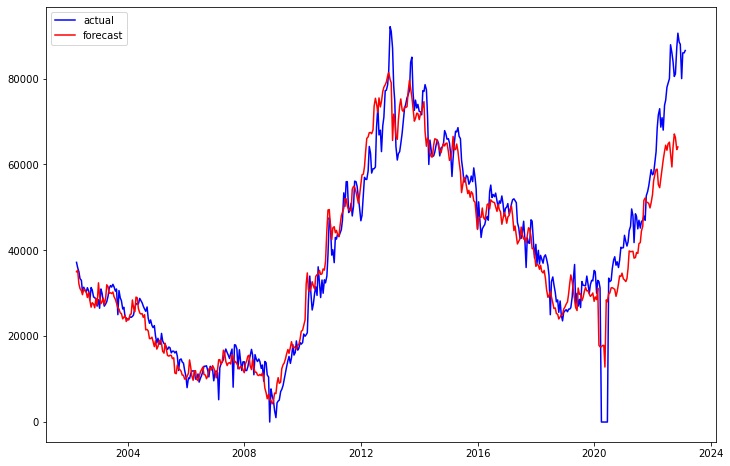

In [119]:
plt.figure(figsize=(12,8))
plt.plot(final_df_a['ds'],final_df_a['y'], color='blue', label = 'actual')
plt.plot(final_df_a['ds'],final_df_a['yhat'], color='red', label = 'forecast')
plt.legend()

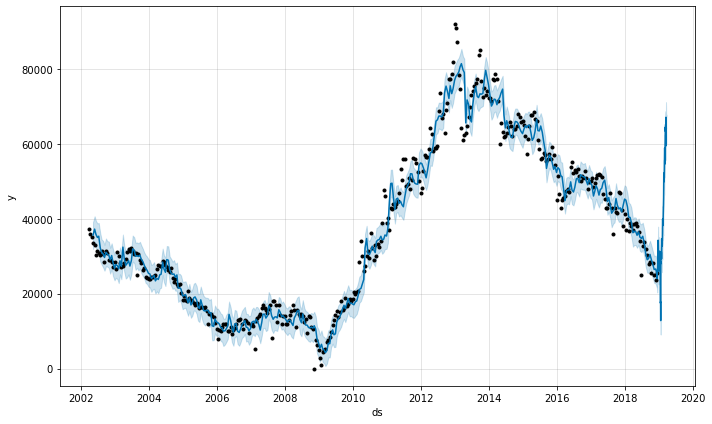

In [120]:
fig_a = m.plot(forecast_a)
# ax_a = fig_a.gca()
# ax_a.plot(test_a["ds"], test_a["y"], 'r.')

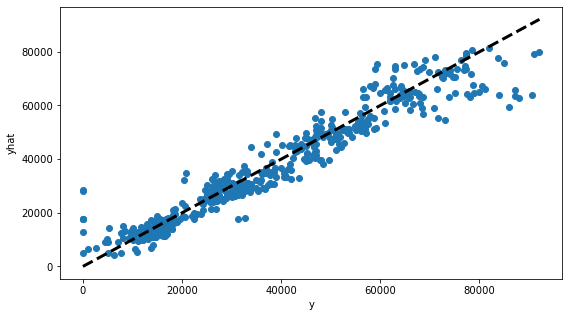

In [121]:
# plot y against yhat
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
ax.scatter(final_df_a['y'], final_df_a['yhat'])
ax.plot([final_df_a['y'].min(), final_df_a['y'].max()], [final_df_a['y'].min(), final_df_a['y'].max()], 'k--', lw=3)
ax.set_xlabel('y')
ax.set_ylabel('yhat')
plt.show()

### Cat A Remodel - RMSE
---

In [122]:
# cross validation
df_cv = cross_validation(m, initial='3650 days', period='30 days', horizon = '1825 days', parallel="processes")
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-05-01,64186.660414,61542.559306,66784.930191,62600,2012-04-25
1,2012-05-15,64007.359422,61419.305429,66437.647841,58001,2012-04-25
2,2012-06-01,65910.444496,63559.797461,68546.397572,59003,2012-04-25
3,2012-06-15,65659.080254,63210.646283,68329.840153,59004,2012-04-25
4,2012-07-01,65671.885357,63119.267761,68188.222235,59421,2012-04-25


In [123]:
# model performance metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,181 days,7.717114e+07,8784.710741,6924.581366,0.093899,0.075069,0.093288,0.337302
1,190 days,7.755512e+07,8806.538596,6955.565059,0.094109,0.075069,0.093588,0.337302
2,191 days,8.015240e+07,8952.787445,7076.499038,0.095643,0.076966,0.095196,0.329365
3,192 days,8.089979e+07,8994.431078,7106.082157,0.096000,0.076966,0.095560,0.329365
4,193 days,8.048775e+07,8971.496550,7094.795634,0.095839,0.076966,0.095373,0.328042


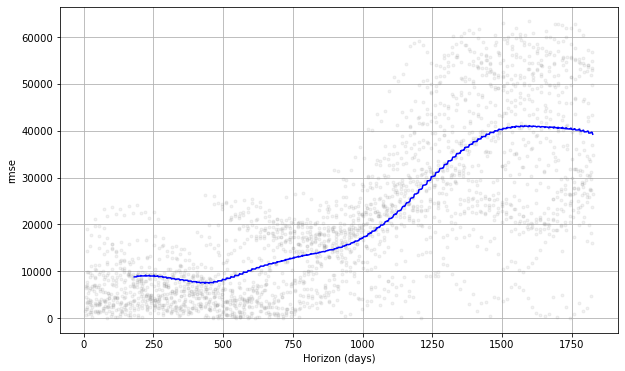

In [124]:
# visualize the performance metrics
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [125]:
metric_a = forecast_a.set_index('ds')[['yhat']].join(df_a.set_index('ds').y).reset_index()

In [126]:
metric_a.tail()

,ds,yhat,y
494,2019-03-21,64033.427841,NaN
495,2019-03-22,67108.678695,NaN
496,2019-03-23,66288.762473,NaN
497,2019-03-24,63468.022198,NaN
498,2019-03-25,64076.320573,NaN


In [127]:
#drop null as we only want to look at the actual values.
metric_a.dropna(inplace=True)

In [128]:
metric_a.tail()

,ds,yhat,y
429,2019-01-15,28123.011745,26170.0
446,2019-02-01,30888.251001,25689.0
460,2019-02-15,39720.382513,26301.0
474,2019-03-01,50910.115604,26309.0
488,2019-03-15,64493.989564,26659.0


In [129]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [130]:
# calculate r2
r2_score(metric_a.y, metric_a.yhat)

0.9492746677993567

In [131]:
# calculate rmse
mean_squared_error(metric_a.y, metric_a.yhat, squared = False)

4785.220334738606

In [132]:
# calculate mape
mean_absolute_percentage_error(metric_a.y, metric_a.yhat)

14.226335319554762

### Cat A - Base vs Remodel

|                	|          **r2**         	| **RMSE** 	| **MAPE** 	|
|:--------------:	|:-----------------------:	|:--------:	|:--------:	|
| **Base Model** 	|          91.31          |    6,264.72    |    18.21    |
|   **Remodel**  	|          94.93          |    4,785.22    |    14.22    |

### Cat A Remodel - Coefficient

In [133]:
coef = regressor_coefficients(m)

In [134]:
coef['abs_coef'] = coef['coef'].apply(lambda x: abs(x))
coef['colors'] = coef['coef'].apply(lambda x: 'green' if x > 0 else 'red')
coef = coef.sort_values('abs_coef', ascending=False)
coef.head(10)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper,abs_coef,colors
4,cat_a_successful_bids_lag,additive,1470.888060,7.814545,7.814545,7.814545,7.814545,green
0,cat_a_quota,additive,1482.751244,-3.431727,-3.431727,-3.431727,3.431727,red
2,total_successful_bids_lag,additive,3855.748756,-3.064350,-3.064350,-3.064350,3.064350,red
6,cat_e_successful_bids_lag,additive,675.957711,1.929761,1.929761,1.929761,1.929761,green
1,cat_e_quota,additive,687.216418,-0.777149,-0.777149,-0.777149,0.777149,red
7,cat_e_bids_received_lag,additive,1060.067164,0.593672,0.593672,0.593672,0.593672,green
12,reg_cat_a_lag,additive,3246.930348,0.502305,0.502305,0.502305,0.502305,green
11,total_reg_lag,additive,8185.253731,-0.419037,-0.419037,-0.419037,0.419037,red
13,reg_cat_b_lag,additive,2643.880597,0.321528,0.321528,0.321528,0.321528,green
5,cat_b_quota_premium_lag,additive,41511.641791,0.233875,0.233875,0.233875,0.233875,green


Text(0.5, 0, 'Regressor')

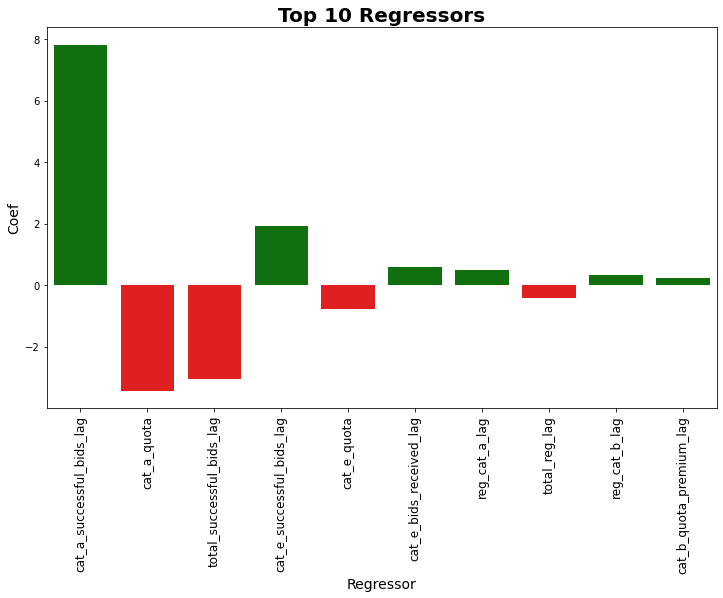

In [135]:
# plot coefficients of features
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x='regressor',
            y='coef',
            data=coef.head(10),
           palette=coef.head(10)['colors'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=12)
ax.set_title('Top 10 Regressors', fontsize=20, fontweight='bold')
ax.set_ylabel('Coef', fontsize=14)
ax.set_xlabel('Regressor', fontsize=14)

### Cat A - Summary

1) The higher the number of susccessful bids in the previous round of bidding, the higher the Cat A premium is expected for the current round.

2) Cat A premium is likely to be higher if the quota is lower.

3) The combination of point 1 and point 2 will lead to higher premium because, in order to ensure a successful bid, people will tend to bid higher

4) Cat A premium also tends to be higher if the number of Cat A registation in the previous month is higher.

## Cat B COE
---

### Cat B Base Model

In [136]:
df_b = df[['data_series', 'cat_b_quota_premium', 'total_quota','cat_a_quota',
          'cat_b_quota','cat_e_quota', 'total_successful_bids_lag',
       'total_bids_received_lag', 'cat_a_successful_bids_lag',
       'cat_a_bids_received_lag', 'cat_a_quota_premium_lag',
       'cat_b_successful_bids_lag', 'cat_b_bids_received_lag',
       'cat_b_quota_premium_lag', 'cat_e_successful_bids_lag',
       'cat_e_bids_received_lag', 'cat_e_quota_premium_lag',
       'total_veh_pop_lag', 'total_cars_lag', 'total_private_hire_cars_lag',
       'total_reg_lag', 'reg_cat_a_lag', 'reg_cat_b_lag', 'total_dereg_lag',
       'dereg_cat_a_lag', 'dereg_cat_b_lag']]

In [137]:
df_b.isnull().sum()

data_series                      0
cat_b_quota_premium              0
total_quota                      0
cat_a_quota                      0
cat_b_quota                      0
cat_e_quota                      0
total_successful_bids_lag        0
total_bids_received_lag          0
cat_a_successful_bids_lag        0
cat_a_bids_received_lag          0
cat_a_quota_premium_lag          0
cat_b_successful_bids_lag        0
cat_b_bids_received_lag          0
cat_b_quota_premium_lag          0
cat_e_successful_bids_lag        0
cat_e_bids_received_lag          0
cat_e_quota_premium_lag          0
total_veh_pop_lag              254
total_cars_lag                 254
total_private_hire_cars_lag    254
total_reg_lag                  254
reg_cat_a_lag                  254
reg_cat_b_lag                  254
total_dereg_lag                254
dereg_cat_a_lag                254
dereg_cat_b_lag                254
dtype: int64

In [138]:
df_b.fillna(method='ffill', inplace=True)

C:\Users\ng_li\AppData\Local\Temp\ipykernel_17012\2391039977.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b.fillna(method='ffill', inplace=True)


In [139]:
df_b.dropna(inplace=True)

C:\Users\ng_li\AppData\Local\Temp\ipykernel_17012\457992463.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b.dropna(inplace=True)


In [140]:
df_b.isnull().sum()

data_series                    0
cat_b_quota_premium            0
total_quota                    0
cat_a_quota                    0
cat_b_quota                    0
cat_e_quota                    0
total_successful_bids_lag      0
total_bids_received_lag        0
cat_a_successful_bids_lag      0
cat_a_bids_received_lag        0
cat_a_quota_premium_lag        0
cat_b_successful_bids_lag      0
cat_b_bids_received_lag        0
cat_b_quota_premium_lag        0
cat_e_successful_bids_lag      0
cat_e_bids_received_lag        0
cat_e_quota_premium_lag        0
total_veh_pop_lag              0
total_cars_lag                 0
total_private_hire_cars_lag    0
total_reg_lag                  0
reg_cat_a_lag                  0
reg_cat_b_lag                  0
total_dereg_lag                0
dereg_cat_a_lag                0
dereg_cat_b_lag                0
dtype: int64

In [141]:
df_b.head()

,data_series,cat_b_quota_premium,total_quota,cat_a_quota,cat_b_quota,cat_e_quota,total_successful_bids_lag,total_bids_received_lag,cat_a_successful_bids_lag,cat_a_bids_received_lag,cat_a_quota_premium_lag,cat_b_successful_bids_lag,cat_b_bids_received_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag,total_veh_pop_lag,total_cars_lag,total_private_hire_cars_lag,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag,total_dereg_lag,dereg_cat_a_lag,dereg_cat_b_lag
3,2002-04-01,39509,3695,1110,558,682,3839,7266,1429,2800,33201,650,1052,34200,744,1594,34501,707986.0,399335.0,8808.0,5668.0,2182.0,1899.0,6453.0,2998.0,1480.0
4,2002-04-15,42101,3800,1149,553,754,3615,7514,1092,2484,37201,551,1119,39509,631,1797,41001,707986.0,399335.0,8808.0,5668.0,2182.0,1899.0,6453.0,2998.0,1480.0
5,2002-05-01,40001,3990,1128,560,960,3781,6298,1148,1890,36000,553,1104,42101,753,1407,42043,706177.0,398487.0,8666.0,9049.0,4030.0,2375.0,10858.0,5038.0,2344.0
6,2002-05-15,38001,3928,1111,552,910,3840,6504,1127,1705,35000,518,1043,40001,930,1880,40001,706177.0,398487.0,8666.0,9049.0,4030.0,2375.0,10858.0,5038.0,2344.0
7,2002-06-01,33001,4060,1111,595,939,3837,5908,1080,1320,33401,541,894,38001,877,1835,38399,704734.0,398050.0,8611.0,8099.0,3275.0,2021.0,9542.0,3883.0,1910.0


In [142]:
m_b = Prophet(holidays=holidays)

In [143]:
df_b.rename(columns={'data_series': 'ds', 'cat_b_quota_premium': 'y'}, inplace=True)

C:\Users\ng_li\AppData\Local\Temp\ipykernel_17012\2292145158.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b.rename(columns={'data_series': 'ds', 'cat_b_quota_premium': 'y'}, inplace=True)


In [144]:
df_b.head()

,ds,y,total_quota,cat_a_quota,cat_b_quota,cat_e_quota,total_successful_bids_lag,total_bids_received_lag,cat_a_successful_bids_lag,cat_a_bids_received_lag,cat_a_quota_premium_lag,cat_b_successful_bids_lag,cat_b_bids_received_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag,total_veh_pop_lag,total_cars_lag,total_private_hire_cars_lag,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag,total_dereg_lag,dereg_cat_a_lag,dereg_cat_b_lag
3,2002-04-01,39509,3695,1110,558,682,3839,7266,1429,2800,33201,650,1052,34200,744,1594,34501,707986.0,399335.0,8808.0,5668.0,2182.0,1899.0,6453.0,2998.0,1480.0
4,2002-04-15,42101,3800,1149,553,754,3615,7514,1092,2484,37201,551,1119,39509,631,1797,41001,707986.0,399335.0,8808.0,5668.0,2182.0,1899.0,6453.0,2998.0,1480.0
5,2002-05-01,40001,3990,1128,560,960,3781,6298,1148,1890,36000,553,1104,42101,753,1407,42043,706177.0,398487.0,8666.0,9049.0,4030.0,2375.0,10858.0,5038.0,2344.0
6,2002-05-15,38001,3928,1111,552,910,3840,6504,1127,1705,35000,518,1043,40001,930,1880,40001,706177.0,398487.0,8666.0,9049.0,4030.0,2375.0,10858.0,5038.0,2344.0
7,2002-06-01,33001,4060,1111,595,939,3837,5908,1080,1320,33401,541,894,38001,877,1835,38399,704734.0,398050.0,8611.0,8099.0,3275.0,2021.0,9542.0,3883.0,1910.0


In [145]:
df_b.shape

(502, 26)

In [146]:
train_b = df_b.iloc[0:402]

test_b = df_b.iloc[402:]

In [147]:
train_b.tail()

,ds,y,total_quota,cat_a_quota,cat_b_quota,cat_e_quota,total_successful_bids_lag,total_bids_received_lag,cat_a_successful_bids_lag,cat_a_bids_received_lag,cat_a_quota_premium_lag,cat_b_successful_bids_lag,cat_b_bids_received_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag,total_veh_pop_lag,total_cars_lag,total_private_hire_cars_lag,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag,total_dereg_lag,dereg_cat_a_lag,dereg_cat_b_lag
400,2018-10-15,31302,4655,1674,1273,539,4598,6673,1665,2059,28457,1241,1886,31301,543,1066,32552,956287.0,550117.0,66998.0,8533.0,2721.0,3208.0,9543.0,4001.0,2749.0
401,2018-11-01,32302,5094,1819,1265,557,4634,6117,1672,1811,25556,1267,1856,31302,527,779,32900,955956.0,550423.0,66410.0,8843.0,2887.0,3280.0,9174.0,3886.0,2556.0
402,2018-11-15,31101,5045,1818,1241,552,4999,7856,1757,2849,28199,1262,2142,32302,544,862,32000,955956.0,550423.0,66410.0,8843.0,2887.0,3280.0,9174.0,3886.0,2556.0
403,2018-12-01,31001,5119,1878,1239,552,4944,6950,1744,2231,25000,1234,1786,31101,546,930,30959,956106.0,551018.0,66273.0,9876.0,3018.0,3719.0,9726.0,3656.0,2634.0
404,2018-12-15,31001,5125,1890,1243,545,5095,6950,1878,2177,23568,1230,1780,31001,546,1021,30851,956106.0,551018.0,66273.0,9876.0,3018.0,3719.0,9726.0,3656.0,2634.0


In [148]:
test_b.head()

,ds,y,total_quota,cat_a_quota,cat_b_quota,cat_e_quota,total_successful_bids_lag,total_bids_received_lag,cat_a_successful_bids_lag,cat_a_bids_received_lag,cat_a_quota_premium_lag,cat_b_successful_bids_lag,cat_b_bids_received_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag,total_veh_pop_lag,total_cars_lag,total_private_hire_cars_lag,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag,total_dereg_lag,dereg_cat_a_lag,dereg_cat_b_lag
405,2019-01-01,32200,5048,1815,1245,546,5099,7189,1887,2729,25501,1235,1804,31001,545,778,31809,956428.0,551407.0,66079.0,9923.0,3238.0,3523.0,9601.0,3872.0,2688.0
406,2019-01-15,33989,5050,1818,1244,540,4997,7169,1804,2707,25920,1242,1818,32200,540,776,32909,956428.0,551407.0,66079.0,9923.0,3238.0,3523.0,9601.0,3872.0,2688.0
407,2019-02-01,34509,4427,1662,1202,403,5024,7790,1818,2864,26170,1230,2119,33989,530,797,33689,957006.0,551575.0,66480.0,9922.0,2930.0,3714.0,9344.0,3465.0,2661.0
408,2019-02-15,35403,4403,1650,1214,407,4372,6483,1653,2371,25689,1169,1937,34509,392,545,35310,957006.0,551575.0,66480.0,9922.0,2930.0,3714.0,9344.0,3465.0,2661.0
409,2019-03-01,36961,4431,1659,1233,408,4393,6445,1650,2261,26301,1213,1993,35403,407,658,36667,959468.0,552763.0,67571.0,11782.0,4111.0,4138.0,9320.0,3438.0,2534.0


In [149]:
for col in df_b.iloc[:,2:]:
    m_b.add_regressor(col, standardize = True)

In [150]:
# Fit the model using the training dataset
m_b.fit(train_b)

22:54:11 - cmdstanpy - INFO - Chain [1] start processing
22:54:11 - cmdstanpy - INFO - Chain [1] done processing


In [151]:
# Create a future dataframe for prediction
future_b = m_b.make_future_dataframe(periods=100)

In [152]:
future_b.shape

(502, 1)

In [153]:
df_b.tail()

,ds,y,total_quota,cat_a_quota,cat_b_quota,cat_e_quota,total_successful_bids_lag,total_bids_received_lag,cat_a_successful_bids_lag,cat_a_bids_received_lag,cat_a_quota_premium_lag,cat_b_successful_bids_lag,cat_b_bids_received_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag,total_veh_pop_lag,total_cars_lag,total_private_hire_cars_lag,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag,total_dereg_lag,dereg_cat_a_lag,dereg_cat_b_lag
500,2022-12-15,108006,1562,473,409,146,1533,2112,454,616,88503,426,568,105501,148,266,110524,994790.0,581297.0,71030.0,4209.0,1019.0,1296.0,3440.0,1028.0,779.0
501,2023-01-01,102002,1533,462,410,146,1545,2249,472,618,88007,409,564,108006,143,273,109600,994820.0,580543.0,71649.0,4371.0,1100.0,1165.0,4341.0,1424.0,990.0
502,2023-01-15,105459,1539,459,408,149,1517,2282,459,649,80000,410,487,102002,146,285,107889,994820.0,580543.0,71649.0,4371.0,1100.0,1165.0,4341.0,1424.0,990.0
503,2023-02-01,105524,1589,509,430,129,1510,2143,456,627,86000,402,514,105459,147,248,107000,995746.0,580332.0,72632.0,4398.0,1077.0,1272.0,3472.0,857.0,742.0
504,2023-02-15,115001,1602,508,436,132,1572,2174,497,663,86000,430,580,105524,126,229,105002,995746.0,580332.0,72632.0,4398.0,1077.0,1272.0,3472.0,857.0,742.0


In [154]:
df_b.columns

Index(['ds', 'y', 'total_quota', 'cat_a_quota', 'cat_b_quota', 'cat_e_quota',
       'total_successful_bids_lag', 'total_bids_received_lag',
       'cat_a_successful_bids_lag', 'cat_a_bids_received_lag',
       'cat_a_quota_premium_lag', 'cat_b_successful_bids_lag',
       'cat_b_bids_received_lag', 'cat_b_quota_premium_lag',
       'cat_e_successful_bids_lag', 'cat_e_bids_received_lag',
       'cat_e_quota_premium_lag', 'total_veh_pop_lag', 'total_cars_lag',
       'total_private_hire_cars_lag', 'total_reg_lag', 'reg_cat_a_lag',
       'reg_cat_b_lag', 'total_dereg_lag', 'dereg_cat_a_lag',
       'dereg_cat_b_lag'],
      dtype='object')

In [155]:
future_b=pd.concat((future_b, df_b[['total_quota','cat_a_quota',
          'cat_b_quota','cat_e_quota', 'total_successful_bids_lag',
       'total_bids_received_lag', 'cat_a_successful_bids_lag',
       'cat_a_bids_received_lag', 'cat_a_quota_premium_lag',
       'cat_b_successful_bids_lag', 'cat_b_bids_received_lag',
       'cat_b_quota_premium_lag', 'cat_e_successful_bids_lag',
       'cat_e_bids_received_lag', 'cat_e_quota_premium_lag',
       'total_veh_pop_lag', 'total_cars_lag', 'total_private_hire_cars_lag',
       'total_reg_lag', 'reg_cat_a_lag', 'reg_cat_b_lag', 'total_dereg_lag',
       'dereg_cat_a_lag', 'dereg_cat_b_lag']]),axis=1)

In [156]:
future_b.head()

,ds,total_quota,cat_a_quota,cat_b_quota,cat_e_quota,total_successful_bids_lag,total_bids_received_lag,cat_a_successful_bids_lag,cat_a_bids_received_lag,cat_a_quota_premium_lag,cat_b_successful_bids_lag,cat_b_bids_received_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag,total_veh_pop_lag,total_cars_lag,total_private_hire_cars_lag,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag,total_dereg_lag,dereg_cat_a_lag,dereg_cat_b_lag
0,2002-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2002-04-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2002-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2002-05-15,3695.0,1110.0,558.0,682.0,3839.0,7266.0,1429.0,2800.0,33201.0,650.0,1052.0,34200.0,744.0,1594.0,34501.0,707986.0,399335.0,8808.0,5668.0,2182.0,1899.0,6453.0,2998.0,1480.0
4,2002-06-01,3800.0,1149.0,553.0,754.0,3615.0,7514.0,1092.0,2484.0,37201.0,551.0,1119.0,39509.0,631.0,1797.0,41001.0,707986.0,399335.0,8808.0,5668.0,2182.0,1899.0,6453.0,2998.0,1480.0


In [157]:
future_b.isnull().sum()

ds                             3
total_quota                    3
cat_a_quota                    3
cat_b_quota                    3
cat_e_quota                    3
total_successful_bids_lag      3
total_bids_received_lag        3
cat_a_successful_bids_lag      3
cat_a_bids_received_lag        3
cat_a_quota_premium_lag        3
cat_b_successful_bids_lag      3
cat_b_bids_received_lag        3
cat_b_quota_premium_lag        3
cat_e_successful_bids_lag      3
cat_e_bids_received_lag        3
cat_e_quota_premium_lag        3
total_veh_pop_lag              3
total_cars_lag                 3
total_private_hire_cars_lag    3
total_reg_lag                  3
reg_cat_a_lag                  3
reg_cat_b_lag                  3
total_dereg_lag                3
dereg_cat_a_lag                3
dereg_cat_b_lag                3
dtype: int64

In [158]:
future_b.dropna(inplace=True)

In [159]:
# Forecast the future dataframe values
forecast_b = m_b.predict(future_b)

In [160]:
final_df_b = pd.concat((forecast_b['yhat'],df_b), axis=1)

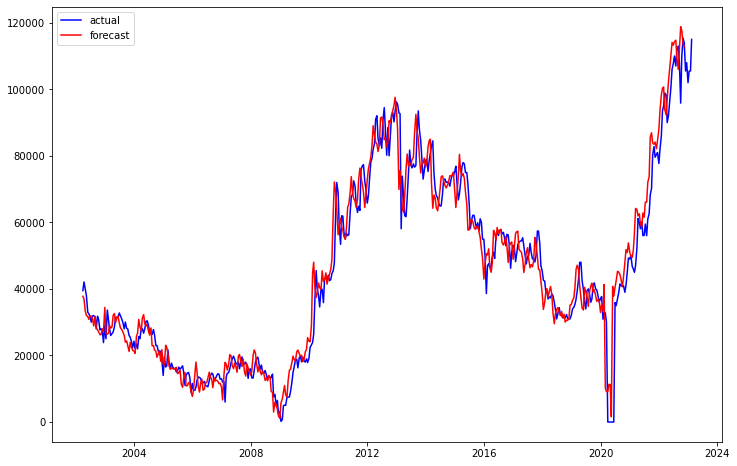

In [161]:
plt.figure(figsize=(12,8))
plt.plot(final_df_b['ds'],final_df_b['y'], color='blue', label = 'actual')
plt.plot(final_df_b['ds'],final_df_b['yhat'], color='red', label = 'forecast')
plt.legend()

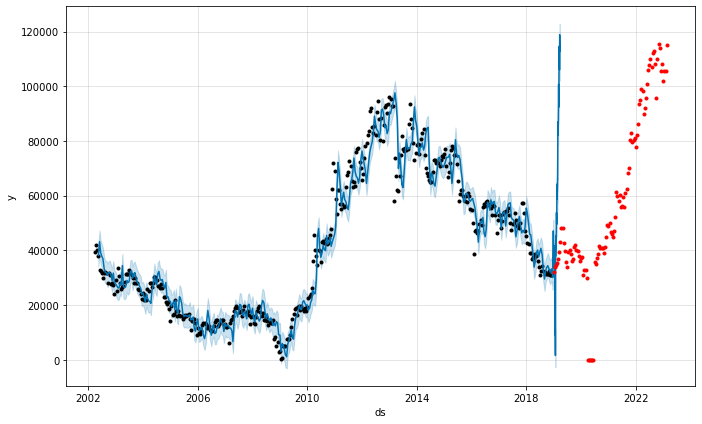

In [162]:
fig_b = m_b.plot(forecast_b)
ax_b = fig_b.gca()
ax_b.plot(test_b["ds"], test_b["y"], 'r.')

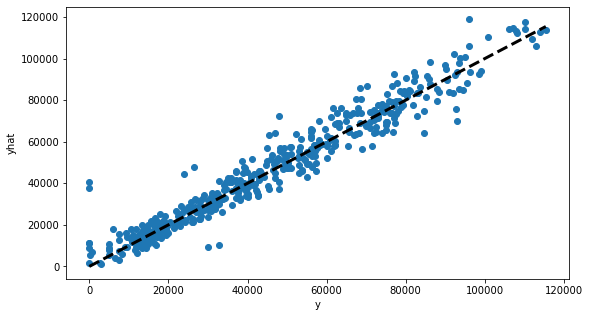

In [163]:
# plot y against yhat
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
ax.scatter(final_df_b['y'], final_df_b['yhat'])
ax.plot([final_df_b['y'].min(), final_df_b['y'].max()], [final_df_b['y'].min(), final_df_b['y'].max()], 'k--', lw=3)
ax.set_xlabel('y')
ax.set_ylabel('yhat')
plt.show()

Similar to Cat A premium, the model doesn't seem to predict very well when the Cat B COE premium is more than 80,000, which is for the most part after 2022.

### Cat B Base Model - RMSE
---

In [164]:
# Cross validation
df_cv = cross_validation(m_b, initial='3650 days', period='30 days', horizon = '1825 days', parallel="processes")
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-05-01,91258.549405,88082.053829,94491.174419,92050,2012-04-25
1,2012-05-15,89270.256740,86107.954682,92268.925828,85216,2012-04-25
2,2012-06-01,86684.127147,83752.367169,89853.030644,83000,2012-04-25
3,2012-06-15,86317.339857,83247.981605,89391.386486,85400,2012-04-25
4,2012-07-01,84808.391006,81596.490362,87779.145913,82289,2012-04-25


In [165]:
# Model performance metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,181 days,7.021325e+07,8379.334615,5858.809982,0.077504,0.054991,0.072084,0.436508
1,190 days,7.672629e+07,8759.354328,6031.177983,0.080359,0.055392,0.074235,0.432540
2,191 days,7.697523e+07,8773.552787,6055.972258,0.080897,0.055392,0.074719,0.428571
3,192 days,7.333774e+07,8563.745508,5977.750766,0.079250,0.055392,0.073535,0.432540
4,193 days,7.333438e+07,8563.549581,5984.881572,0.079321,0.055392,0.073608,0.429894


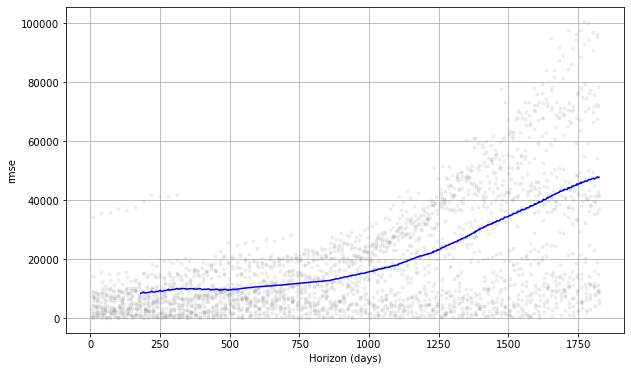

In [166]:
# Visualize the performance metrics
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [167]:
metric_b = forecast_b.set_index('ds')[['yhat']].join(df_b.set_index('ds').y).reset_index()

In [168]:
metric_b.tail()

,ds,yhat,y
494,2019-03-21,112248.701734,NaN
495,2019-03-22,118825.206506,NaN
496,2019-03-23,117596.136361,NaN
497,2019-03-24,113582.506018,NaN
498,2019-03-25,112753.718546,NaN


In [169]:
#drop null as we only want to look at the actual values.
metric_b.dropna(inplace=True)

In [170]:
metric_b.tail()

,ds,yhat,y
429,2019-01-15,32914.583096,33989.0
446,2019-02-01,42735.120947,34509.0
460,2019-02-15,61956.080054,35403.0
474,2019-03-01,84148.720177,36961.0
488,2019-03-15,114109.253998,39401.0


In [171]:
# calculate r2
r2_score(metric_b.y, metric_b.yhat)

0.8947835979744851

In [172]:
# calculate rmse
mean_squared_error(metric_b.y, metric_b.yhat, squared = False)

8130.419111267986

In [173]:
# calculate mape
mean_absolute_percentage_error(metric_b.y, metric_b.yhat)

0.20868999752146694

### Cat B Remodel

In [174]:
# select regressors where correlation is more than 60%
df_b = df[['data_series', 'cat_b_quota_premium', 'total_quota','cat_a_quota',
           'cat_e_quota','total_successful_bids_lag',
       'total_bids_received_lag', 'cat_a_successful_bids_lag',
       'cat_a_bids_received_lag', 'cat_a_quota_premium_lag',
       'cat_b_quota_premium_lag', 'cat_e_successful_bids_lag',
       'cat_e_bids_received_lag', 'cat_e_quota_premium_lag',
       'total_veh_pop_lag', 'total_cars_lag',
       'total_reg_lag', 'reg_cat_a_lag', 'reg_cat_b_lag', 
       'dereg_cat_a_lag'
          ]]

In [175]:
df_b.isnull().sum()

data_series                    0
cat_b_quota_premium            0
total_quota                    0
cat_a_quota                    0
cat_e_quota                    0
total_successful_bids_lag      0
total_bids_received_lag        0
cat_a_successful_bids_lag      0
cat_a_bids_received_lag        0
cat_a_quota_premium_lag        0
cat_b_quota_premium_lag        0
cat_e_successful_bids_lag      0
cat_e_bids_received_lag        0
cat_e_quota_premium_lag        0
total_veh_pop_lag            254
total_cars_lag               254
total_reg_lag                254
reg_cat_a_lag                254
reg_cat_b_lag                254
dereg_cat_a_lag              254
dtype: int64

In [176]:
df_b.fillna(method='ffill', inplace=True)

C:\Users\ng_li\AppData\Local\Temp\ipykernel_17012\2391039977.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b.fillna(method='ffill', inplace=True)


In [177]:
df_b.dropna(inplace=True)

C:\Users\ng_li\AppData\Local\Temp\ipykernel_17012\457992463.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b.dropna(inplace=True)


In [178]:
df_b.isnull().sum()

data_series                  0
cat_b_quota_premium          0
total_quota                  0
cat_a_quota                  0
cat_e_quota                  0
total_successful_bids_lag    0
total_bids_received_lag      0
cat_a_successful_bids_lag    0
cat_a_bids_received_lag      0
cat_a_quota_premium_lag      0
cat_b_quota_premium_lag      0
cat_e_successful_bids_lag    0
cat_e_bids_received_lag      0
cat_e_quota_premium_lag      0
total_veh_pop_lag            0
total_cars_lag               0
total_reg_lag                0
reg_cat_a_lag                0
reg_cat_b_lag                0
dereg_cat_a_lag              0
dtype: int64

In [179]:
df_b.head()

,data_series,cat_b_quota_premium,total_quota,cat_a_quota,cat_e_quota,total_successful_bids_lag,total_bids_received_lag,cat_a_successful_bids_lag,cat_a_bids_received_lag,cat_a_quota_premium_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag,total_veh_pop_lag,total_cars_lag,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag,dereg_cat_a_lag
3,2002-04-01,39509,3695,1110,682,3839,7266,1429,2800,33201,34200,744,1594,34501,707986.0,399335.0,5668.0,2182.0,1899.0,2998.0
4,2002-04-15,42101,3800,1149,754,3615,7514,1092,2484,37201,39509,631,1797,41001,707986.0,399335.0,5668.0,2182.0,1899.0,2998.0
5,2002-05-01,40001,3990,1128,960,3781,6298,1148,1890,36000,42101,753,1407,42043,706177.0,398487.0,9049.0,4030.0,2375.0,5038.0
6,2002-05-15,38001,3928,1111,910,3840,6504,1127,1705,35000,40001,930,1880,40001,706177.0,398487.0,9049.0,4030.0,2375.0,5038.0
7,2002-06-01,33001,4060,1111,939,3837,5908,1080,1320,33401,38001,877,1835,38399,704734.0,398050.0,8099.0,3275.0,2021.0,3883.0


In [180]:
df_b.rename(columns={'data_series': 'ds', 'cat_b_quota_premium': 'y'}, inplace=True)

C:\Users\ng_li\AppData\Local\Temp\ipykernel_17012\2292145158.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_b.rename(columns={'data_series': 'ds', 'cat_b_quota_premium': 'y'}, inplace=True)


In [181]:
df_b.head()

,ds,y,total_quota,cat_a_quota,cat_e_quota,total_successful_bids_lag,total_bids_received_lag,cat_a_successful_bids_lag,cat_a_bids_received_lag,cat_a_quota_premium_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag,total_veh_pop_lag,total_cars_lag,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag,dereg_cat_a_lag
3,2002-04-01,39509,3695,1110,682,3839,7266,1429,2800,33201,34200,744,1594,34501,707986.0,399335.0,5668.0,2182.0,1899.0,2998.0
4,2002-04-15,42101,3800,1149,754,3615,7514,1092,2484,37201,39509,631,1797,41001,707986.0,399335.0,5668.0,2182.0,1899.0,2998.0
5,2002-05-01,40001,3990,1128,960,3781,6298,1148,1890,36000,42101,753,1407,42043,706177.0,398487.0,9049.0,4030.0,2375.0,5038.0
6,2002-05-15,38001,3928,1111,910,3840,6504,1127,1705,35000,40001,930,1880,40001,706177.0,398487.0,9049.0,4030.0,2375.0,5038.0
7,2002-06-01,33001,4060,1111,939,3837,5908,1080,1320,33401,38001,877,1835,38399,704734.0,398050.0,8099.0,3275.0,2021.0,3883.0


In [182]:
df_b.shape

(502, 20)

In [183]:
train_b = df_b.iloc[0:402]

test_b = df_b.iloc[402:]

In [184]:
train_b.tail()

,ds,y,total_quota,cat_a_quota,cat_e_quota,total_successful_bids_lag,total_bids_received_lag,cat_a_successful_bids_lag,cat_a_bids_received_lag,cat_a_quota_premium_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag,total_veh_pop_lag,total_cars_lag,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag,dereg_cat_a_lag
400,2018-10-15,31302,4655,1674,539,4598,6673,1665,2059,28457,31301,543,1066,32552,956287.0,550117.0,8533.0,2721.0,3208.0,4001.0
401,2018-11-01,32302,5094,1819,557,4634,6117,1672,1811,25556,31302,527,779,32900,955956.0,550423.0,8843.0,2887.0,3280.0,3886.0
402,2018-11-15,31101,5045,1818,552,4999,7856,1757,2849,28199,32302,544,862,32000,955956.0,550423.0,8843.0,2887.0,3280.0,3886.0
403,2018-12-01,31001,5119,1878,552,4944,6950,1744,2231,25000,31101,546,930,30959,956106.0,551018.0,9876.0,3018.0,3719.0,3656.0
404,2018-12-15,31001,5125,1890,545,5095,6950,1878,2177,23568,31001,546,1021,30851,956106.0,551018.0,9876.0,3018.0,3719.0,3656.0


In [185]:
test_b.head()

,ds,y,total_quota,cat_a_quota,cat_e_quota,total_successful_bids_lag,total_bids_received_lag,cat_a_successful_bids_lag,cat_a_bids_received_lag,cat_a_quota_premium_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag,total_veh_pop_lag,total_cars_lag,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag,dereg_cat_a_lag
405,2019-01-01,32200,5048,1815,546,5099,7189,1887,2729,25501,31001,545,778,31809,956428.0,551407.0,9923.0,3238.0,3523.0,3872.0
406,2019-01-15,33989,5050,1818,540,4997,7169,1804,2707,25920,32200,540,776,32909,956428.0,551407.0,9923.0,3238.0,3523.0,3872.0
407,2019-02-01,34509,4427,1662,403,5024,7790,1818,2864,26170,33989,530,797,33689,957006.0,551575.0,9922.0,2930.0,3714.0,3465.0
408,2019-02-15,35403,4403,1650,407,4372,6483,1653,2371,25689,34509,392,545,35310,957006.0,551575.0,9922.0,2930.0,3714.0,3465.0
409,2019-03-01,36961,4431,1659,408,4393,6445,1650,2261,26301,35403,407,658,36667,959468.0,552763.0,11782.0,4111.0,4138.0,3438.0


In [186]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.25, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 2.5, 5.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m_b = Prophet(holidays=holidays,**params).fit(train_b)  # Fit model with given params
    df_cv = cross_validation(m_b, cutoffs=cutoffs, horizon='180 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

22:54:22 - cmdstanpy - INFO - Chain [1] start processing
22:54:22 - cmdstanpy - INFO - Chain [1] done processing
22:54:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
22:54:22 - cmdstanpy - INFO - Chain [1] start processing
22:54:22 - cmdstanpy - INFO - Chain [1] done processing
22:54:28 - cmdstanpy - INFO - Chain [1] start processing
22:54:28 - cmdstanpy - INFO - Chain [1] done processing
22:54:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
22:54:28 - cmdstanpy - INFO - Chain [1] start processing
22:54:28 - cmdstanpy - INFO - Chain [1] done processing
22:54:34 - cmdstanpy - INFO - Chain [1] start processing
22:54:34 - cmdstanpy - INFO - Chain [1] done processing
22:54:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newto

    changepoint_prior_scale  seasonality_prior_scale          rmse
0                     0.001                     0.01  27861.269889
1                     0.001                     0.10  28261.064366
2                     0.001                     1.00  28235.189670
3                     0.001                     2.50  28230.053105
4                     0.001                     5.00  28226.821538
5                     0.001                    10.00  28226.189467
6                     0.010                     0.01  27835.154968
7                     0.010                     0.10  28363.871334
8                     0.010                     1.00  28311.450416
9                     0.010                     2.50  28378.560260
10                    0.010                     5.00  28413.637445
11                    0.010                    10.00  28431.306429
12                    0.100                     0.01  11041.884031
13                    0.100                     0.10  10911.71

In [187]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0}


In [188]:
m_b = Prophet(holidays=holidays, changepoint_prior_scale=0.5, seasonality_prior_scale=1.0)

In [189]:
for col in df_b.iloc[:,2:]:
    m_b.add_regressor(col, standardize = True)

In [190]:
# Fit the model using the training dataset
m_b.fit(train_b)

22:57:27 - cmdstanpy - INFO - Chain [1] start processing
22:57:27 - cmdstanpy - INFO - Chain [1] done processing


In [191]:
# Create a future dataframe for prediction
future_b = m_b.make_future_dataframe(periods=100)

In [192]:
future_b.shape

(502, 1)

In [193]:
df_b.tail()

,ds,y,total_quota,cat_a_quota,cat_e_quota,total_successful_bids_lag,total_bids_received_lag,cat_a_successful_bids_lag,cat_a_bids_received_lag,cat_a_quota_premium_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag,total_veh_pop_lag,total_cars_lag,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag,dereg_cat_a_lag
500,2022-12-15,108006,1562,473,146,1533,2112,454,616,88503,105501,148,266,110524,994790.0,581297.0,4209.0,1019.0,1296.0,1028.0
501,2023-01-01,102002,1533,462,146,1545,2249,472,618,88007,108006,143,273,109600,994820.0,580543.0,4371.0,1100.0,1165.0,1424.0
502,2023-01-15,105459,1539,459,149,1517,2282,459,649,80000,102002,146,285,107889,994820.0,580543.0,4371.0,1100.0,1165.0,1424.0
503,2023-02-01,105524,1589,509,129,1510,2143,456,627,86000,105459,147,248,107000,995746.0,580332.0,4398.0,1077.0,1272.0,857.0
504,2023-02-15,115001,1602,508,132,1572,2174,497,663,86000,105524,126,229,105002,995746.0,580332.0,4398.0,1077.0,1272.0,857.0


In [194]:
df_b.columns

Index(['ds', 'y', 'total_quota', 'cat_a_quota', 'cat_e_quota',
       'total_successful_bids_lag', 'total_bids_received_lag',
       'cat_a_successful_bids_lag', 'cat_a_bids_received_lag',
       'cat_a_quota_premium_lag', 'cat_b_quota_premium_lag',
       'cat_e_successful_bids_lag', 'cat_e_bids_received_lag',
       'cat_e_quota_premium_lag', 'total_veh_pop_lag', 'total_cars_lag',
       'total_reg_lag', 'reg_cat_a_lag', 'reg_cat_b_lag', 'dereg_cat_a_lag'],
      dtype='object')

In [195]:
future_b=pd.concat((future_b, df_b[['total_quota','cat_a_quota',
           'cat_e_quota','total_successful_bids_lag',
       'total_bids_received_lag', 'cat_a_successful_bids_lag',
       'cat_a_bids_received_lag', 'cat_a_quota_premium_lag',
       'cat_b_quota_premium_lag', 'cat_e_successful_bids_lag',
       'cat_e_bids_received_lag', 'cat_e_quota_premium_lag',
       'total_veh_pop_lag', 'total_cars_lag',
       'total_reg_lag', 'reg_cat_a_lag', 'reg_cat_b_lag', 
       'dereg_cat_a_lag']]),axis=1)

In [196]:
future_b.head()

,ds,total_quota,cat_a_quota,cat_e_quota,total_successful_bids_lag,total_bids_received_lag,cat_a_successful_bids_lag,cat_a_bids_received_lag,cat_a_quota_premium_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag,total_veh_pop_lag,total_cars_lag,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag,dereg_cat_a_lag
0,2002-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2002-04-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2002-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2002-05-15,3695.0,1110.0,682.0,3839.0,7266.0,1429.0,2800.0,33201.0,34200.0,744.0,1594.0,34501.0,707986.0,399335.0,5668.0,2182.0,1899.0,2998.0
4,2002-06-01,3800.0,1149.0,754.0,3615.0,7514.0,1092.0,2484.0,37201.0,39509.0,631.0,1797.0,41001.0,707986.0,399335.0,5668.0,2182.0,1899.0,2998.0


In [197]:
future_b.isnull().sum()

ds                           3
total_quota                  3
cat_a_quota                  3
cat_e_quota                  3
total_successful_bids_lag    3
total_bids_received_lag      3
cat_a_successful_bids_lag    3
cat_a_bids_received_lag      3
cat_a_quota_premium_lag      3
cat_b_quota_premium_lag      3
cat_e_successful_bids_lag    3
cat_e_bids_received_lag      3
cat_e_quota_premium_lag      3
total_veh_pop_lag            3
total_cars_lag               3
total_reg_lag                3
reg_cat_a_lag                3
reg_cat_b_lag                3
dereg_cat_a_lag              3
dtype: int64

In [198]:
future_b.dropna(inplace=True)

In [199]:
# Forecast the future dataframe values
forecast_b = m_b.predict(future_b)

In [200]:
final_df_b = pd.concat((forecast_b['yhat'],df_b), axis=1)

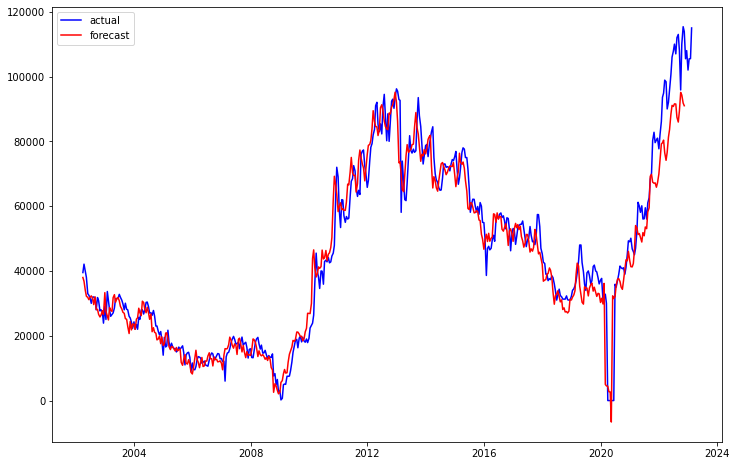

In [201]:
plt.figure(figsize=(12,8))
plt.plot(final_df_b['ds'],final_df_b['y'], color='blue', label = 'actual')
plt.plot(final_df_b['ds'],final_df_b['yhat'], color='red', label = 'forecast')
plt.legend()

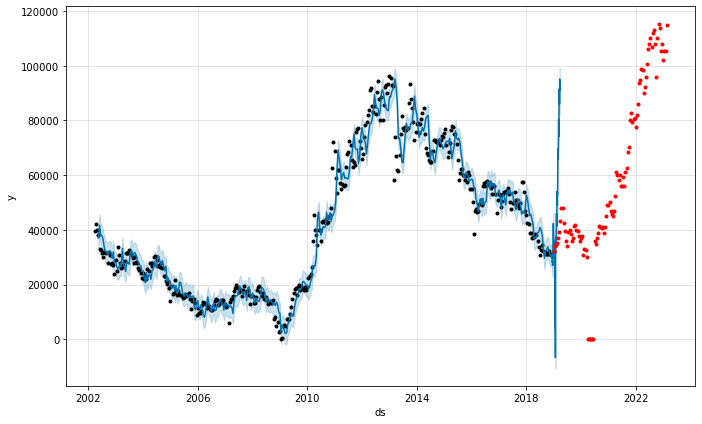

In [202]:
fig_b = m_b.plot(forecast_b)
ax_b = fig_b.gca()
ax_b.plot(test_b["ds"], test_b["y"], 'r.')

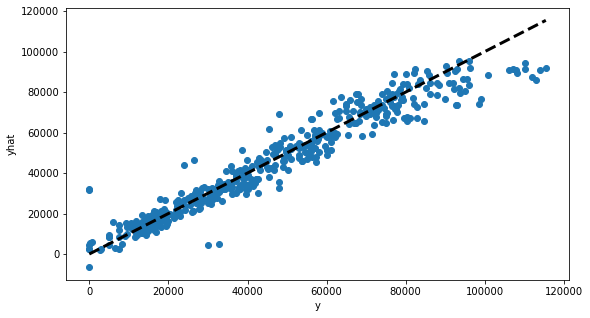

In [203]:
# Plot y against yhat
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
ax.scatter(final_df_b['y'], final_df_b['yhat'])
ax.plot([final_df_b['y'].min(), final_df_b['y'].max()], [final_df_b['y'].min(), final_df_b['y'].max()], 'k--', lw=3)
ax.set_xlabel('y')
ax.set_ylabel('yhat')
plt.show()

### Cat B Remodel - RMSE
---

In [204]:
# Cross validation
df_cv = cross_validation(m_b, initial='3650 days', period='30 days', horizon = '1825 days', parallel="processes")
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-05-01,90871.895460,87782.887295,93757.792924,92050,2012-04-25
1,2012-05-15,88461.195260,85652.127824,91533.294571,85216,2012-04-25
2,2012-06-01,88199.500403,85288.353588,91068.084747,83000,2012-04-25
3,2012-06-15,88540.945512,85479.920780,91334.785443,85400,2012-04-25
4,2012-07-01,87047.337434,84274.786145,90019.953196,82289,2012-04-25


In [205]:
# Model performance metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,181 days,8.920727e+07,9444.960121,6658.301366,0.089306,0.059397,0.081500,0.384921
1,190 days,9.668572e+07,9832.889849,6839.707875,0.092312,0.059846,0.083714,0.384921
2,191 days,9.803244e+07,9901.133521,6906.029629,0.093495,0.060176,0.084727,0.380952
3,192 days,9.481922e+07,9737.516306,6872.873120,0.092422,0.060688,0.084093,0.380952
4,193 days,9.522552e+07,9758.356236,6902.871741,0.092777,0.060688,0.084421,0.378307


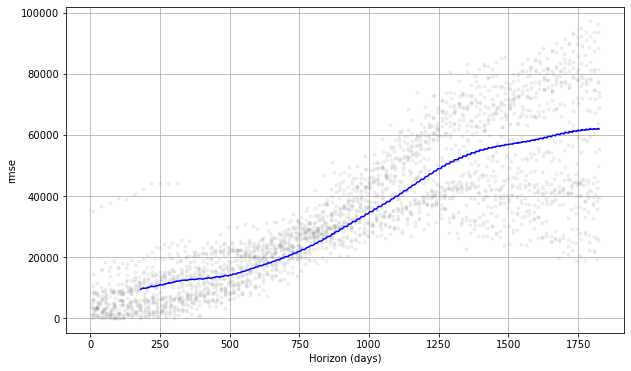

In [206]:
# Visualize the performance metrics
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [207]:
metric_b = forecast_b.set_index('ds')[['yhat']].join(df_b.set_index('ds').y).reset_index()

In [208]:
metric_b.tail()

,ds,yhat,y
494,2019-03-21,89349.698648,NaN
495,2019-03-22,95096.951920,NaN
496,2019-03-23,94302.714049,NaN
497,2019-03-24,91813.974591,NaN
498,2019-03-25,90991.800520,NaN


In [209]:
#drop null as we only want to look at the actual values.
metric_b.dropna(inplace=True)

In [210]:
metric_b.tail()

,ds,yhat,y
429,2019-01-15,30267.958587,33989.0
446,2019-02-01,35032.443959,34509.0
460,2019-02-15,51238.597774,35403.0
474,2019-03-01,67188.501251,36961.0
488,2019-03-15,91107.592139,39401.0


In [211]:
# calculate r2
r2_score(metric_b.y, metric_b.yhat)

0.9258994722564635

In [212]:
# calculate rmse
mean_squared_error(metric_b.y, metric_b.yhat, squared = False)

6823.101952004821

In [213]:
# calculate mape
mean_absolute_percentage_error(metric_b.y, metric_b.yhat)

0.1867803455185137

### Cat B - Base vs Remodel

|                	|          **r2**         	| **RMSE** 	| **MAPE** 	|
|:--------------:	|:-----------------------:	|:--------:	|:--------:	|
| **Base Model** 	|          89.48          |    8,130.42    |    20.87    |
|   **Remodel**  	|          92.59          |    6,823.10    |    18.68    |

### Cat B Remodel - Coefficients

In [214]:
coef = regressor_coefficients(m_b)

In [215]:
coef['abs_coef'] = coef['coef'].apply(lambda x: abs(x))
coef['colors'] = coef['coef'].apply(lambda x: 'green' if x > 0 else 'red')
coef = coef.sort_values('abs_coef', ascending=False)
coef.head(10)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper,abs_coef,colors
5,cat_a_successful_bids_lag,additive,1470.888060,7.585117,7.585117,7.585117,7.585117,green
9,cat_e_successful_bids_lag,additive,675.957711,6.635872,6.635872,6.635872,6.635872,green
3,total_successful_bids_lag,additive,3855.748756,-4.039718,-4.039718,-4.039718,4.039718,red
6,cat_a_bids_received_lag,additive,2059.116915,-3.502320,-3.502320,-3.502320,3.502320,red
4,total_bids_received_lag,additive,5536.922886,2.744266,2.744266,2.744266,2.744266,green
0,total_quota,additive,3918.888060,-2.210070,-2.210070,-2.210070,2.210070,red
16,reg_cat_b_lag,additive,2643.880597,2.108820,2.108820,2.108820,2.108820,green
2,cat_e_quota,additive,687.216418,-1.940874,-1.940874,-1.940874,1.940874,red
1,cat_a_quota,additive,1482.751244,1.256600,1.256600,1.256600,1.256600,green
10,cat_e_bids_received_lag,additive,1060.067164,-0.812703,-0.812703,-0.812703,0.812703,red


Text(0.5, 0, 'Regressor')

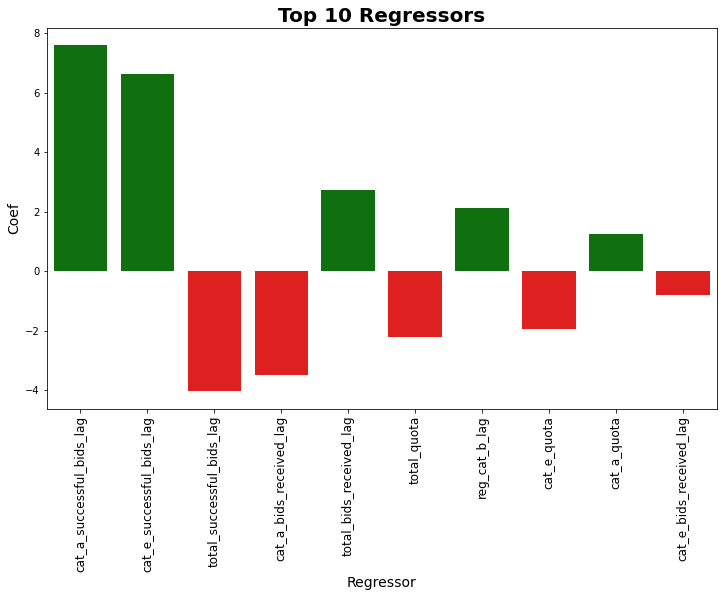

In [216]:
# plot coefficients of features
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x='regressor',
            y='coef',
            data=coef.head(10),
           palette=coef.head(10)['colors'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=12)
ax.set_title('Top 10 Regressors', fontsize=20, fontweight='bold')
ax.set_ylabel('Coef', fontsize=14)
ax.set_xlabel('Regressor', fontsize=14)

### Cat B - Summary

1) When the number of successful bids for both Cat A and Cat E are higher, Cat B COE premium tend to be higher. Higher number of successful bids for both Cat A and Cat E could mean a general trend where there are more cars sales and therefore higher demand for COE.

2) When the number of total bids received is higher in the previous round of bidding, Cat B COE premium is expected to be higher. Since Cat B COE are for larger cars which are more expensive, a higher number of bids received could signal that in general the economy is doing well and more people can afford to buy new cars or even larger cars.

3) When the number of Cat E quota is lower, it drives the Cat B premium up. This is because, bidders cannot hope to turn to Cat E to secure a COE. Hence, they have to bid higher for Cat B COE, to make sure that they got a COE.

## Cat E COE
---

### Cat E Base Model

In [217]:
df_e = df[['data_series', 'cat_e_quota_premium', 'total_quota','cat_a_quota',
          'cat_b_quota','cat_e_quota', 'total_successful_bids_lag',
       'total_bids_received_lag', 'cat_a_successful_bids_lag',
       'cat_a_bids_received_lag', 'cat_a_quota_premium_lag',
       'cat_b_successful_bids_lag', 'cat_b_bids_received_lag',
       'cat_b_quota_premium_lag', 'cat_e_successful_bids_lag',
       'cat_e_bids_received_lag', 'cat_e_quota_premium_lag',
       'total_veh_pop_lag', 'total_cars_lag', 'total_private_hire_cars_lag',
       'total_reg_lag', 'reg_cat_a_lag', 'reg_cat_b_lag', 'total_dereg_lag',
       'dereg_cat_a_lag', 'dereg_cat_b_lag']]

In [218]:
df_e.isnull().sum()

data_series                      0
cat_e_quota_premium              0
total_quota                      0
cat_a_quota                      0
cat_b_quota                      0
cat_e_quota                      0
total_successful_bids_lag        0
total_bids_received_lag          0
cat_a_successful_bids_lag        0
cat_a_bids_received_lag          0
cat_a_quota_premium_lag          0
cat_b_successful_bids_lag        0
cat_b_bids_received_lag          0
cat_b_quota_premium_lag          0
cat_e_successful_bids_lag        0
cat_e_bids_received_lag          0
cat_e_quota_premium_lag          0
total_veh_pop_lag              254
total_cars_lag                 254
total_private_hire_cars_lag    254
total_reg_lag                  254
reg_cat_a_lag                  254
reg_cat_b_lag                  254
total_dereg_lag                254
dereg_cat_a_lag                254
dereg_cat_b_lag                254
dtype: int64

In [219]:
df_e.fillna(method='ffill', inplace=True)

C:\Users\ng_li\AppData\Local\Temp\ipykernel_17012\3906510318.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_e.fillna(method='ffill', inplace=True)


In [220]:
df_e.dropna(inplace=True)

C:\Users\ng_li\AppData\Local\Temp\ipykernel_17012\91914562.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_e.dropna(inplace=True)


In [221]:
df_e.isnull().sum()

data_series                    0
cat_e_quota_premium            0
total_quota                    0
cat_a_quota                    0
cat_b_quota                    0
cat_e_quota                    0
total_successful_bids_lag      0
total_bids_received_lag        0
cat_a_successful_bids_lag      0
cat_a_bids_received_lag        0
cat_a_quota_premium_lag        0
cat_b_successful_bids_lag      0
cat_b_bids_received_lag        0
cat_b_quota_premium_lag        0
cat_e_successful_bids_lag      0
cat_e_bids_received_lag        0
cat_e_quota_premium_lag        0
total_veh_pop_lag              0
total_cars_lag                 0
total_private_hire_cars_lag    0
total_reg_lag                  0
reg_cat_a_lag                  0
reg_cat_b_lag                  0
total_dereg_lag                0
dereg_cat_a_lag                0
dereg_cat_b_lag                0
dtype: int64

In [222]:
df_e.head()

,data_series,cat_e_quota_premium,total_quota,cat_a_quota,cat_b_quota,cat_e_quota,total_successful_bids_lag,total_bids_received_lag,cat_a_successful_bids_lag,cat_a_bids_received_lag,cat_a_quota_premium_lag,cat_b_successful_bids_lag,cat_b_bids_received_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag,total_veh_pop_lag,total_cars_lag,total_private_hire_cars_lag,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag,total_dereg_lag,dereg_cat_a_lag,dereg_cat_b_lag
3,2002-04-01,41001,3695,1110,558,682,3839,7266,1429,2800,33201,650,1052,34200,744,1594,34501,707986.0,399335.0,8808.0,5668.0,2182.0,1899.0,6453.0,2998.0,1480.0
4,2002-04-15,42043,3800,1149,553,754,3615,7514,1092,2484,37201,551,1119,39509,631,1797,41001,707986.0,399335.0,8808.0,5668.0,2182.0,1899.0,6453.0,2998.0,1480.0
5,2002-05-01,40001,3990,1128,560,960,3781,6298,1148,1890,36000,553,1104,42101,753,1407,42043,706177.0,398487.0,8666.0,9049.0,4030.0,2375.0,10858.0,5038.0,2344.0
6,2002-05-15,38399,3928,1111,552,910,3840,6504,1127,1705,35000,518,1043,40001,930,1880,40001,706177.0,398487.0,8666.0,9049.0,4030.0,2375.0,10858.0,5038.0,2344.0
7,2002-06-01,34397,4060,1111,595,939,3837,5908,1080,1320,33401,541,894,38001,877,1835,38399,704734.0,398050.0,8611.0,8099.0,3275.0,2021.0,9542.0,3883.0,1910.0


In [223]:
m_e = Prophet(holidays=holidays)

In [224]:
df_e.columns

Index(['data_series', 'cat_e_quota_premium', 'total_quota', 'cat_a_quota',
       'cat_b_quota', 'cat_e_quota', 'total_successful_bids_lag',
       'total_bids_received_lag', 'cat_a_successful_bids_lag',
       'cat_a_bids_received_lag', 'cat_a_quota_premium_lag',
       'cat_b_successful_bids_lag', 'cat_b_bids_received_lag',
       'cat_b_quota_premium_lag', 'cat_e_successful_bids_lag',
       'cat_e_bids_received_lag', 'cat_e_quota_premium_lag',
       'total_veh_pop_lag', 'total_cars_lag', 'total_private_hire_cars_lag',
       'total_reg_lag', 'reg_cat_a_lag', 'reg_cat_b_lag', 'total_dereg_lag',
       'dereg_cat_a_lag', 'dereg_cat_b_lag'],
      dtype='object')

In [225]:
df_e.rename(columns={'data_series': 'ds', 'cat_e_quota_premium': 'y'}, inplace=True)

C:\Users\ng_li\AppData\Local\Temp\ipykernel_17012\3760933748.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_e.rename(columns={'data_series': 'ds', 'cat_e_quota_premium': 'y'}, inplace=True)


In [226]:
df_e.head()

,ds,y,total_quota,cat_a_quota,cat_b_quota,cat_e_quota,total_successful_bids_lag,total_bids_received_lag,cat_a_successful_bids_lag,cat_a_bids_received_lag,cat_a_quota_premium_lag,cat_b_successful_bids_lag,cat_b_bids_received_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag,total_veh_pop_lag,total_cars_lag,total_private_hire_cars_lag,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag,total_dereg_lag,dereg_cat_a_lag,dereg_cat_b_lag
3,2002-04-01,41001,3695,1110,558,682,3839,7266,1429,2800,33201,650,1052,34200,744,1594,34501,707986.0,399335.0,8808.0,5668.0,2182.0,1899.0,6453.0,2998.0,1480.0
4,2002-04-15,42043,3800,1149,553,754,3615,7514,1092,2484,37201,551,1119,39509,631,1797,41001,707986.0,399335.0,8808.0,5668.0,2182.0,1899.0,6453.0,2998.0,1480.0
5,2002-05-01,40001,3990,1128,560,960,3781,6298,1148,1890,36000,553,1104,42101,753,1407,42043,706177.0,398487.0,8666.0,9049.0,4030.0,2375.0,10858.0,5038.0,2344.0
6,2002-05-15,38399,3928,1111,552,910,3840,6504,1127,1705,35000,518,1043,40001,930,1880,40001,706177.0,398487.0,8666.0,9049.0,4030.0,2375.0,10858.0,5038.0,2344.0
7,2002-06-01,34397,4060,1111,595,939,3837,5908,1080,1320,33401,541,894,38001,877,1835,38399,704734.0,398050.0,8611.0,8099.0,3275.0,2021.0,9542.0,3883.0,1910.0


In [227]:
df_e.shape

(502, 26)

In [228]:
train_e = df_e.iloc[0:402]

test_e = df_e.iloc[402:]

In [229]:
train_e.tail()

,ds,y,total_quota,cat_a_quota,cat_b_quota,cat_e_quota,total_successful_bids_lag,total_bids_received_lag,cat_a_successful_bids_lag,cat_a_bids_received_lag,cat_a_quota_premium_lag,cat_b_successful_bids_lag,cat_b_bids_received_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag,total_veh_pop_lag,total_cars_lag,total_private_hire_cars_lag,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag,total_dereg_lag,dereg_cat_a_lag,dereg_cat_b_lag
400,2018-10-15,32900,4655,1674,1273,539,4598,6673,1665,2059,28457,1241,1886,31301,543,1066,32552,956287.0,550117.0,66998.0,8533.0,2721.0,3208.0,9543.0,4001.0,2749.0
401,2018-11-01,32000,5094,1819,1265,557,4634,6117,1672,1811,25556,1267,1856,31302,527,779,32900,955956.0,550423.0,66410.0,8843.0,2887.0,3280.0,9174.0,3886.0,2556.0
402,2018-11-15,30959,5045,1818,1241,552,4999,7856,1757,2849,28199,1262,2142,32302,544,862,32000,955956.0,550423.0,66410.0,8843.0,2887.0,3280.0,9174.0,3886.0,2556.0
403,2018-12-01,30851,5119,1878,1239,552,4944,6950,1744,2231,25000,1234,1786,31101,546,930,30959,956106.0,551018.0,66273.0,9876.0,3018.0,3719.0,9726.0,3656.0,2634.0
404,2018-12-15,31809,5125,1890,1243,545,5095,6950,1878,2177,23568,1230,1780,31001,546,1021,30851,956106.0,551018.0,66273.0,9876.0,3018.0,3719.0,9726.0,3656.0,2634.0


In [230]:
test_e.head()

,ds,y,total_quota,cat_a_quota,cat_b_quota,cat_e_quota,total_successful_bids_lag,total_bids_received_lag,cat_a_successful_bids_lag,cat_a_bids_received_lag,cat_a_quota_premium_lag,cat_b_successful_bids_lag,cat_b_bids_received_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag,total_veh_pop_lag,total_cars_lag,total_private_hire_cars_lag,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag,total_dereg_lag,dereg_cat_a_lag,dereg_cat_b_lag
405,2019-01-01,32909,5048,1815,1245,546,5099,7189,1887,2729,25501,1235,1804,31001,545,778,31809,956428.0,551407.0,66079.0,9923.0,3238.0,3523.0,9601.0,3872.0,2688.0
406,2019-01-15,33689,5050,1818,1244,540,4997,7169,1804,2707,25920,1242,1818,32200,540,776,32909,956428.0,551407.0,66079.0,9923.0,3238.0,3523.0,9601.0,3872.0,2688.0
407,2019-02-01,35310,4427,1662,1202,403,5024,7790,1818,2864,26170,1230,2119,33989,530,797,33689,957006.0,551575.0,66480.0,9922.0,2930.0,3714.0,9344.0,3465.0,2661.0
408,2019-02-15,36667,4403,1650,1214,407,4372,6483,1653,2371,25689,1169,1937,34509,392,545,35310,957006.0,551575.0,66480.0,9922.0,2930.0,3714.0,9344.0,3465.0,2661.0
409,2019-03-01,37620,4431,1659,1233,408,4393,6445,1650,2261,26301,1213,1993,35403,407,658,36667,959468.0,552763.0,67571.0,11782.0,4111.0,4138.0,9320.0,3438.0,2534.0


In [231]:
df_e.iloc[:,2:]

,total_quota,cat_a_quota,cat_b_quota,cat_e_quota,total_successful_bids_lag,total_bids_received_lag,cat_a_successful_bids_lag,cat_a_bids_received_lag,cat_a_quota_premium_lag,cat_b_successful_bids_lag,cat_b_bids_received_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag,total_veh_pop_lag,total_cars_lag,total_private_hire_cars_lag,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag,total_dereg_lag,dereg_cat_a_lag,dereg_cat_b_lag
3,3695,1110,558,682,3839,7266,1429,2800,33201,650,1052,34200,744,1594,34501,707986.0,399335.0,8808.0,5668.0,2182.0,1899.0,6453.0,2998.0,1480.0
4,3800,1149,553,754,3615,7514,1092,2484,37201,551,1119,39509,631,1797,41001,707986.0,399335.0,8808.0,5668.0,2182.0,1899.0,6453.0,2998.0,1480.0
5,3990,1128,560,960,3781,6298,1148,1890,36000,553,1104,42101,753,1407,42043,706177.0,398487.0,8666.0,9049.0,4030.0,2375.0,10858.0,5038.0,2344.0
6,3928,1111,552,910,3840,6504,1127,1705,35000,518,1043,40001,930,1880,40001,706177.0,398487.0,8666.0,9049.0,4030.0,2375.0,10858.0,5038.0,2344.0
7,4060,1111,595,939,3837,5908,1080,1320,33401,541,894,38001,877,1835,38399,704734.0,398050.0,8611.0,8099.0,3275.0,2021.0,9542.0,3883.0,1910.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,1562,473,409,146,1533,2112,454,616,88503,426,568,105501,148,266,110524,994790.0,581297.0,71030.0,4209.0,1019.0,1296.0,3440.0,1028.0,779.0
501,1533,462,410,146,1545,2249,472,618,88007,409,564,108006,143,273,109600,994820.0,580543.0,71649.0,4371.0,1100.0,1165.0,4341.0,1424.0,990.0
502,1539,459,408,149,1517,2282,459,649,80000,410,487,102002,146,285,107889,994820.0,580543.0,71649.0,4371.0,1100.0,1165.0,4341.0,1424.0,990.0
503,1589,509,430,129,1510,2143,456,627,86000,402,514,105459,147,248,107000,995746.0,580332.0,72632.0,4398.0,1077.0,1272.0,3472.0,857.0,742.0


In [232]:
for col in df_e.iloc[:,2:]:
    m_e.add_regressor(col, standardize = True)

In [233]:
# Fit the model using the training dataset
m_e.fit(train_e)

22:57:41 - cmdstanpy - INFO - Chain [1] start processing
22:57:41 - cmdstanpy - INFO - Chain [1] done processing


In [234]:
# Create a future dataframe for prediction
future_e = m_e.make_future_dataframe(periods=100)

In [235]:
future_e.shape

(502, 1)

In [236]:
df_e.tail()

,ds,y,total_quota,cat_a_quota,cat_b_quota,cat_e_quota,total_successful_bids_lag,total_bids_received_lag,cat_a_successful_bids_lag,cat_a_bids_received_lag,cat_a_quota_premium_lag,cat_b_successful_bids_lag,cat_b_bids_received_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag,total_veh_pop_lag,total_cars_lag,total_private_hire_cars_lag,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag,total_dereg_lag,dereg_cat_a_lag,dereg_cat_b_lag
500,2022-12-15,109600,1562,473,409,146,1533,2112,454,616,88503,426,568,105501,148,266,110524,994790.0,581297.0,71030.0,4209.0,1019.0,1296.0,3440.0,1028.0,779.0
501,2023-01-01,107889,1533,462,410,146,1545,2249,472,618,88007,409,564,108006,143,273,109600,994820.0,580543.0,71649.0,4371.0,1100.0,1165.0,4341.0,1424.0,990.0
502,2023-01-15,107000,1539,459,408,149,1517,2282,459,649,80000,410,487,102002,146,285,107889,994820.0,580543.0,71649.0,4371.0,1100.0,1165.0,4341.0,1424.0,990.0
503,2023-02-01,105002,1589,509,430,129,1510,2143,456,627,86000,402,514,105459,147,248,107000,995746.0,580332.0,72632.0,4398.0,1077.0,1272.0,3472.0,857.0,742.0
504,2023-02-15,118001,1602,508,436,132,1572,2174,497,663,86000,430,580,105524,126,229,105002,995746.0,580332.0,72632.0,4398.0,1077.0,1272.0,3472.0,857.0,742.0


In [237]:
df_e.columns

Index(['ds', 'y', 'total_quota', 'cat_a_quota', 'cat_b_quota', 'cat_e_quota',
       'total_successful_bids_lag', 'total_bids_received_lag',
       'cat_a_successful_bids_lag', 'cat_a_bids_received_lag',
       'cat_a_quota_premium_lag', 'cat_b_successful_bids_lag',
       'cat_b_bids_received_lag', 'cat_b_quota_premium_lag',
       'cat_e_successful_bids_lag', 'cat_e_bids_received_lag',
       'cat_e_quota_premium_lag', 'total_veh_pop_lag', 'total_cars_lag',
       'total_private_hire_cars_lag', 'total_reg_lag', 'reg_cat_a_lag',
       'reg_cat_b_lag', 'total_dereg_lag', 'dereg_cat_a_lag',
       'dereg_cat_b_lag'],
      dtype='object')

In [238]:
future_e=pd.concat((future_e, df_e[[ 'total_quota','cat_a_quota',
          'cat_b_quota','cat_e_quota', 'total_successful_bids_lag',
       'total_bids_received_lag', 'cat_a_successful_bids_lag',
       'cat_a_bids_received_lag', 'cat_a_quota_premium_lag',
       'cat_b_successful_bids_lag', 'cat_b_bids_received_lag',
       'cat_b_quota_premium_lag', 'cat_e_successful_bids_lag',
       'cat_e_bids_received_lag', 'cat_e_quota_premium_lag',
       'total_veh_pop_lag', 'total_cars_lag', 'total_private_hire_cars_lag',
       'total_reg_lag', 'reg_cat_a_lag', 'reg_cat_b_lag', 'total_dereg_lag',
       'dereg_cat_a_lag', 'dereg_cat_b_lag']]),axis=1)

In [239]:
future_e.head()

,ds,total_quota,cat_a_quota,cat_b_quota,cat_e_quota,total_successful_bids_lag,total_bids_received_lag,cat_a_successful_bids_lag,cat_a_bids_received_lag,cat_a_quota_premium_lag,cat_b_successful_bids_lag,cat_b_bids_received_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag,total_veh_pop_lag,total_cars_lag,total_private_hire_cars_lag,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag,total_dereg_lag,dereg_cat_a_lag,dereg_cat_b_lag
0,2002-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2002-04-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2002-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2002-05-15,3695.0,1110.0,558.0,682.0,3839.0,7266.0,1429.0,2800.0,33201.0,650.0,1052.0,34200.0,744.0,1594.0,34501.0,707986.0,399335.0,8808.0,5668.0,2182.0,1899.0,6453.0,2998.0,1480.0
4,2002-06-01,3800.0,1149.0,553.0,754.0,3615.0,7514.0,1092.0,2484.0,37201.0,551.0,1119.0,39509.0,631.0,1797.0,41001.0,707986.0,399335.0,8808.0,5668.0,2182.0,1899.0,6453.0,2998.0,1480.0


In [240]:
future_e.isnull().sum()

ds                             3
total_quota                    3
cat_a_quota                    3
cat_b_quota                    3
cat_e_quota                    3
total_successful_bids_lag      3
total_bids_received_lag        3
cat_a_successful_bids_lag      3
cat_a_bids_received_lag        3
cat_a_quota_premium_lag        3
cat_b_successful_bids_lag      3
cat_b_bids_received_lag        3
cat_b_quota_premium_lag        3
cat_e_successful_bids_lag      3
cat_e_bids_received_lag        3
cat_e_quota_premium_lag        3
total_veh_pop_lag              3
total_cars_lag                 3
total_private_hire_cars_lag    3
total_reg_lag                  3
reg_cat_a_lag                  3
reg_cat_b_lag                  3
total_dereg_lag                3
dereg_cat_a_lag                3
dereg_cat_b_lag                3
dtype: int64

In [241]:
future_e.dropna(inplace=True)

In [242]:
# Forecast the future dataframe values
forecast_e = m_e.predict(future_e)

In [243]:
final_df_e = pd.concat((forecast_e['yhat'],df_e), axis=1)

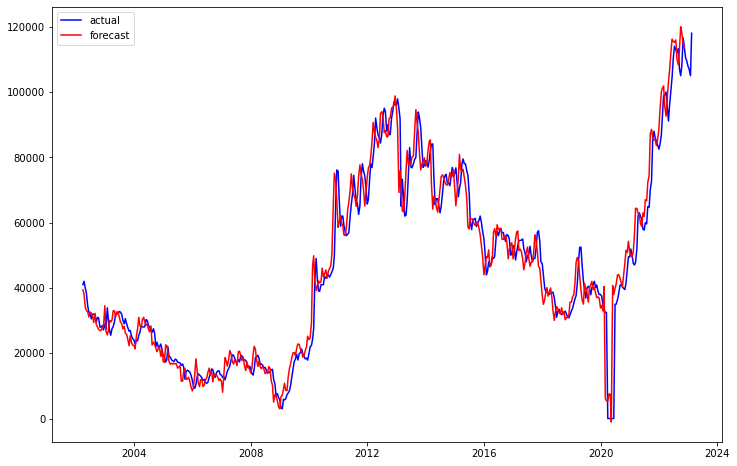

In [244]:
plt.figure(figsize=(12,8))
plt.plot(final_df_e['ds'],final_df_e['y'], color='blue', label = 'actual')
plt.plot(final_df_e['ds'],final_df_e['yhat'], color='red', label = 'forecast')
plt.legend()

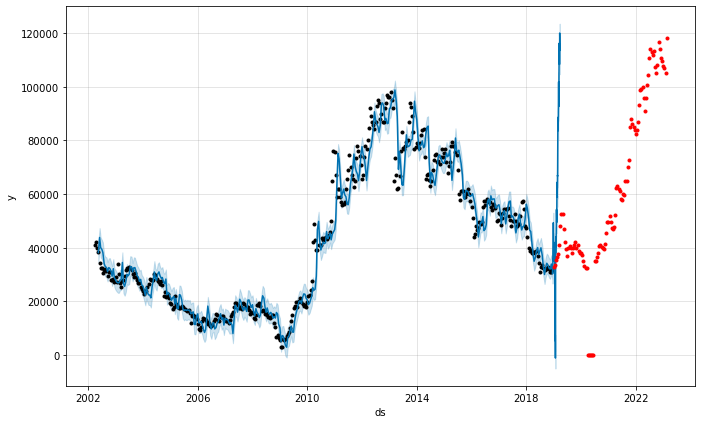

In [245]:
fig_e = m_e.plot(forecast_e)
ax_e = fig_e.gca()
ax_e.plot(test_e["ds"], test_e["y"], 'r.')

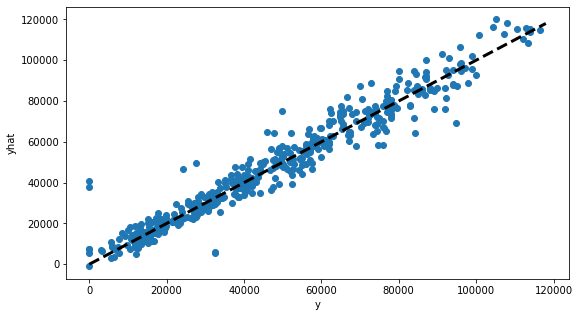

In [246]:
# Plot y against yhat
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
ax.scatter(final_df_e['y'], final_df_e['yhat'])
ax.plot([final_df_e['y'].min(), final_df_e['y'].max()], [final_df_e['y'].min(), final_df_e['y'].max()], 'k--', lw=3)
ax.set_xlabel('y')
ax.set_ylabel('yhat')
plt.show()

In general, the forecast is trending the actual premium very closely, although there are a few outliers.

### Cat E Base Model - RMSE
---

In [247]:
# Cross validation
df_cv = cross_validation(m_e, initial='3650 days', period='30 days', horizon = '1825 days', parallel="processes")
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-05-01,91320.030806,88322.387625,94332.321479,88990,2012-04-25
1,2012-05-15,89023.388568,86192.926177,91865.213804,86889,2012-04-25
2,2012-06-01,86783.322890,84031.043816,89531.647640,85889,2012-04-25
3,2012-06-15,85672.809776,82833.541288,88681.444380,84389,2012-04-25
4,2012-07-01,84189.546257,81504.534036,87104.200446,86999,2012-04-25


In [248]:
# Model performance metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,181 days,4.620511e+07,6797.433974,4613.970604,0.059502,0.035377,0.056826,0.527778
1,190 days,5.007269e+07,7076.205599,4727.345559,0.061281,0.035377,0.058231,0.527778
2,191 days,5.071826e+07,7121.675608,4772.979621,0.062074,0.035518,0.058949,0.523810
3,192 days,4.858959e+07,6970.623014,4740.994789,0.061338,0.035518,0.058445,0.523810
4,193 days,4.850006e+07,6964.198640,4734.813190,0.061226,0.035518,0.058341,0.525132


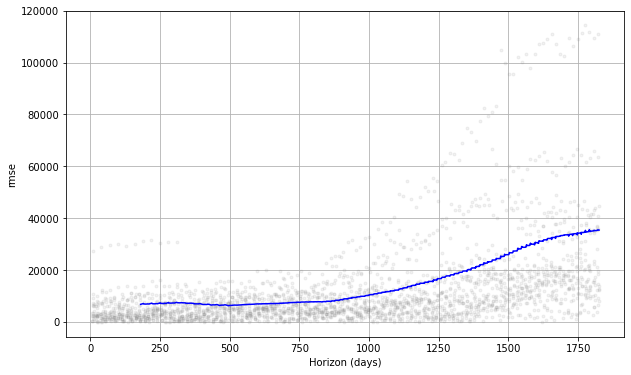

In [249]:
# Visualize the performance metrics
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [250]:
metric_e = forecast_e.set_index('ds')[['yhat']].join(df_e.set_index('ds').y).reset_index()

In [251]:
metric_e.tail()

,ds,yhat,y
494,2019-03-21,112589.791785,NaN
495,2019-03-22,120001.326320,NaN
496,2019-03-23,118171.371621,NaN
497,2019-03-24,114784.928289,NaN
498,2019-03-25,113568.982652,NaN


In [252]:
#drop null as we only want to look at the actual values.
metric_e.dropna(inplace=True)

In [253]:
metric_e.tail()

,ds,yhat,y
429,2019-01-15,33847.959514,33689.0
446,2019-02-01,41657.425505,35310.0
460,2019-02-15,62856.580685,36667.0
474,2019-03-01,85324.913819,37620.0
488,2019-03-15,116189.066700,41000.0


In [254]:
# calculate r2
r2_score(metric_e.y, metric_e.yhat)

0.8931147772217555

In [255]:
# calculate rmse
mean_squared_error(metric_e.y, metric_e.yhat, squared = False)

8245.024101443692

In [256]:
# calculate mape
mean_absolute_percentage_error(metric_e.y, metric_e.yhat)

0.14125366947471713

### Cat E Remodel

In [257]:
# select regressors where correlation is more than 60%
df_e = df[['data_series', 'cat_e_quota_premium', 'total_quota','cat_a_quota',
          'cat_e_quota', 'total_successful_bids_lag',
       'total_bids_received_lag', 'cat_a_successful_bids_lag',
       'cat_a_bids_received_lag', 'cat_a_quota_premium_lag',
       'cat_b_quota_premium_lag', 'cat_e_successful_bids_lag',
       'cat_e_bids_received_lag', 'cat_e_quota_premium_lag',
       'total_veh_pop_lag', 'total_cars_lag', 
       'total_reg_lag', 'reg_cat_a_lag', 'reg_cat_b_lag', 'dereg_cat_a_lag'
          ]]

In [258]:
df_e.isnull().sum()

data_series                    0
cat_e_quota_premium            0
total_quota                    0
cat_a_quota                    0
cat_e_quota                    0
total_successful_bids_lag      0
total_bids_received_lag        0
cat_a_successful_bids_lag      0
cat_a_bids_received_lag        0
cat_a_quota_premium_lag        0
cat_b_quota_premium_lag        0
cat_e_successful_bids_lag      0
cat_e_bids_received_lag        0
cat_e_quota_premium_lag        0
total_veh_pop_lag            254
total_cars_lag               254
total_reg_lag                254
reg_cat_a_lag                254
reg_cat_b_lag                254
dereg_cat_a_lag              254
dtype: int64

In [259]:
df_e.fillna(method='ffill', inplace=True)

C:\Users\ng_li\AppData\Local\Temp\ipykernel_17012\3906510318.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_e.fillna(method='ffill', inplace=True)


In [260]:
df_e.dropna(inplace=True)

C:\Users\ng_li\AppData\Local\Temp\ipykernel_17012\91914562.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_e.dropna(inplace=True)


In [261]:
df_e.isnull().sum()

data_series                  0
cat_e_quota_premium          0
total_quota                  0
cat_a_quota                  0
cat_e_quota                  0
total_successful_bids_lag    0
total_bids_received_lag      0
cat_a_successful_bids_lag    0
cat_a_bids_received_lag      0
cat_a_quota_premium_lag      0
cat_b_quota_premium_lag      0
cat_e_successful_bids_lag    0
cat_e_bids_received_lag      0
cat_e_quota_premium_lag      0
total_veh_pop_lag            0
total_cars_lag               0
total_reg_lag                0
reg_cat_a_lag                0
reg_cat_b_lag                0
dereg_cat_a_lag              0
dtype: int64

In [262]:
df_e.head()

,data_series,cat_e_quota_premium,total_quota,cat_a_quota,cat_e_quota,total_successful_bids_lag,total_bids_received_lag,cat_a_successful_bids_lag,cat_a_bids_received_lag,cat_a_quota_premium_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag,total_veh_pop_lag,total_cars_lag,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag,dereg_cat_a_lag
3,2002-04-01,41001,3695,1110,682,3839,7266,1429,2800,33201,34200,744,1594,34501,707986.0,399335.0,5668.0,2182.0,1899.0,2998.0
4,2002-04-15,42043,3800,1149,754,3615,7514,1092,2484,37201,39509,631,1797,41001,707986.0,399335.0,5668.0,2182.0,1899.0,2998.0
5,2002-05-01,40001,3990,1128,960,3781,6298,1148,1890,36000,42101,753,1407,42043,706177.0,398487.0,9049.0,4030.0,2375.0,5038.0
6,2002-05-15,38399,3928,1111,910,3840,6504,1127,1705,35000,40001,930,1880,40001,706177.0,398487.0,9049.0,4030.0,2375.0,5038.0
7,2002-06-01,34397,4060,1111,939,3837,5908,1080,1320,33401,38001,877,1835,38399,704734.0,398050.0,8099.0,3275.0,2021.0,3883.0


In [263]:
df_e.columns

Index(['data_series', 'cat_e_quota_premium', 'total_quota', 'cat_a_quota',
       'cat_e_quota', 'total_successful_bids_lag', 'total_bids_received_lag',
       'cat_a_successful_bids_lag', 'cat_a_bids_received_lag',
       'cat_a_quota_premium_lag', 'cat_b_quota_premium_lag',
       'cat_e_successful_bids_lag', 'cat_e_bids_received_lag',
       'cat_e_quota_premium_lag', 'total_veh_pop_lag', 'total_cars_lag',
       'total_reg_lag', 'reg_cat_a_lag', 'reg_cat_b_lag', 'dereg_cat_a_lag'],
      dtype='object')

In [264]:
df_e.rename(columns={'data_series': 'ds', 'cat_e_quota_premium': 'y'}, inplace=True)

C:\Users\ng_li\AppData\Local\Temp\ipykernel_17012\3760933748.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_e.rename(columns={'data_series': 'ds', 'cat_e_quota_premium': 'y'}, inplace=True)


In [265]:
df_e.head()

,ds,y,total_quota,cat_a_quota,cat_e_quota,total_successful_bids_lag,total_bids_received_lag,cat_a_successful_bids_lag,cat_a_bids_received_lag,cat_a_quota_premium_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag,total_veh_pop_lag,total_cars_lag,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag,dereg_cat_a_lag
3,2002-04-01,41001,3695,1110,682,3839,7266,1429,2800,33201,34200,744,1594,34501,707986.0,399335.0,5668.0,2182.0,1899.0,2998.0
4,2002-04-15,42043,3800,1149,754,3615,7514,1092,2484,37201,39509,631,1797,41001,707986.0,399335.0,5668.0,2182.0,1899.0,2998.0
5,2002-05-01,40001,3990,1128,960,3781,6298,1148,1890,36000,42101,753,1407,42043,706177.0,398487.0,9049.0,4030.0,2375.0,5038.0
6,2002-05-15,38399,3928,1111,910,3840,6504,1127,1705,35000,40001,930,1880,40001,706177.0,398487.0,9049.0,4030.0,2375.0,5038.0
7,2002-06-01,34397,4060,1111,939,3837,5908,1080,1320,33401,38001,877,1835,38399,704734.0,398050.0,8099.0,3275.0,2021.0,3883.0


In [266]:
df_e.shape

(502, 20)

In [267]:
train_e = df_e.iloc[0:402]

test_e = df_e.iloc[402:]

In [268]:
train_e.tail()

,ds,y,total_quota,cat_a_quota,cat_e_quota,total_successful_bids_lag,total_bids_received_lag,cat_a_successful_bids_lag,cat_a_bids_received_lag,cat_a_quota_premium_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag,total_veh_pop_lag,total_cars_lag,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag,dereg_cat_a_lag
400,2018-10-15,32900,4655,1674,539,4598,6673,1665,2059,28457,31301,543,1066,32552,956287.0,550117.0,8533.0,2721.0,3208.0,4001.0
401,2018-11-01,32000,5094,1819,557,4634,6117,1672,1811,25556,31302,527,779,32900,955956.0,550423.0,8843.0,2887.0,3280.0,3886.0
402,2018-11-15,30959,5045,1818,552,4999,7856,1757,2849,28199,32302,544,862,32000,955956.0,550423.0,8843.0,2887.0,3280.0,3886.0
403,2018-12-01,30851,5119,1878,552,4944,6950,1744,2231,25000,31101,546,930,30959,956106.0,551018.0,9876.0,3018.0,3719.0,3656.0
404,2018-12-15,31809,5125,1890,545,5095,6950,1878,2177,23568,31001,546,1021,30851,956106.0,551018.0,9876.0,3018.0,3719.0,3656.0


In [269]:
test_e.head()

,ds,y,total_quota,cat_a_quota,cat_e_quota,total_successful_bids_lag,total_bids_received_lag,cat_a_successful_bids_lag,cat_a_bids_received_lag,cat_a_quota_premium_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag,total_veh_pop_lag,total_cars_lag,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag,dereg_cat_a_lag
405,2019-01-01,32909,5048,1815,546,5099,7189,1887,2729,25501,31001,545,778,31809,956428.0,551407.0,9923.0,3238.0,3523.0,3872.0
406,2019-01-15,33689,5050,1818,540,4997,7169,1804,2707,25920,32200,540,776,32909,956428.0,551407.0,9923.0,3238.0,3523.0,3872.0
407,2019-02-01,35310,4427,1662,403,5024,7790,1818,2864,26170,33989,530,797,33689,957006.0,551575.0,9922.0,2930.0,3714.0,3465.0
408,2019-02-15,36667,4403,1650,407,4372,6483,1653,2371,25689,34509,392,545,35310,957006.0,551575.0,9922.0,2930.0,3714.0,3465.0
409,2019-03-01,37620,4431,1659,408,4393,6445,1650,2261,26301,35403,407,658,36667,959468.0,552763.0,11782.0,4111.0,4138.0,3438.0


In [270]:
df_e.iloc[:,2:]

,total_quota,cat_a_quota,cat_e_quota,total_successful_bids_lag,total_bids_received_lag,cat_a_successful_bids_lag,cat_a_bids_received_lag,cat_a_quota_premium_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag,total_veh_pop_lag,total_cars_lag,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag,dereg_cat_a_lag
3,3695,1110,682,3839,7266,1429,2800,33201,34200,744,1594,34501,707986.0,399335.0,5668.0,2182.0,1899.0,2998.0
4,3800,1149,754,3615,7514,1092,2484,37201,39509,631,1797,41001,707986.0,399335.0,5668.0,2182.0,1899.0,2998.0
5,3990,1128,960,3781,6298,1148,1890,36000,42101,753,1407,42043,706177.0,398487.0,9049.0,4030.0,2375.0,5038.0
6,3928,1111,910,3840,6504,1127,1705,35000,40001,930,1880,40001,706177.0,398487.0,9049.0,4030.0,2375.0,5038.0
7,4060,1111,939,3837,5908,1080,1320,33401,38001,877,1835,38399,704734.0,398050.0,8099.0,3275.0,2021.0,3883.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,1562,473,146,1533,2112,454,616,88503,105501,148,266,110524,994790.0,581297.0,4209.0,1019.0,1296.0,1028.0
501,1533,462,146,1545,2249,472,618,88007,108006,143,273,109600,994820.0,580543.0,4371.0,1100.0,1165.0,1424.0
502,1539,459,149,1517,2282,459,649,80000,102002,146,285,107889,994820.0,580543.0,4371.0,1100.0,1165.0,1424.0
503,1589,509,129,1510,2143,456,627,86000,105459,147,248,107000,995746.0,580332.0,4398.0,1077.0,1272.0,857.0


In [271]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.25, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 2.5, 5.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m_e = Prophet(holidays=holidays,**params).fit(train_e)  # Fit model with given params
    df_cv = cross_validation(m_e, cutoffs=cutoffs, horizon='180 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

22:57:52 - cmdstanpy - INFO - Chain [1] start processing
22:57:52 - cmdstanpy - INFO - Chain [1] done processing
22:57:52 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
22:57:52 - cmdstanpy - INFO - Chain [1] start processing
22:57:53 - cmdstanpy - INFO - Chain [1] done processing
22:57:59 - cmdstanpy - INFO - Chain [1] start processing
22:57:59 - cmdstanpy - INFO - Chain [1] done processing
22:57:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newton.
22:57:59 - cmdstanpy - INFO - Chain [1] start processing
22:58:00 - cmdstanpy - INFO - Chain [1] done processing
22:58:07 - cmdstanpy - INFO - Chain [1] start processing
22:58:07 - cmdstanpy - INFO - Chain [1] done processing
22:58:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Unknown error
Optimization terminated abnormally. Falling back to Newto

    changepoint_prior_scale  seasonality_prior_scale          rmse
0                     0.001                     0.01  28304.432652
1                     0.001                     0.10  28905.016032
2                     0.001                     1.00  28974.580595
3                     0.001                     2.50  28970.294028
4                     0.001                     5.00  28971.181969
5                     0.001                    10.00  28970.826390
6                     0.010                     0.01  28647.155735
7                     0.010                     0.10  28977.884338
8                     0.010                     1.00  29134.149100
9                     0.010                     2.50  29073.804417
10                    0.010                     5.00  28981.861928
11                    0.010                    10.00  29126.027252
12                    0.100                     0.01  11560.147614
13                    0.100                     0.10  11349.11

In [272]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01}


In [273]:
m_e = Prophet(holidays=holidays, changepoint_prior_scale=0.5, seasonality_prior_scale=0.01)

In [274]:
for col in df_e.iloc[:,2:]:
    m_e.add_regressor(col, standardize = True)

In [275]:
# Fit the model using the training dataset
m_e.fit(train_e)

23:33:26 - cmdstanpy - INFO - Chain [1] start processing
23:33:26 - cmdstanpy - INFO - Chain [1] done processing


In [276]:
# Create a future dataframe for prediction
future_e = m_e.make_future_dataframe(periods=100)

In [277]:
future_e.shape

(502, 1)

In [278]:
df_e.tail()

,ds,y,total_quota,cat_a_quota,cat_e_quota,total_successful_bids_lag,total_bids_received_lag,cat_a_successful_bids_lag,cat_a_bids_received_lag,cat_a_quota_premium_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag,total_veh_pop_lag,total_cars_lag,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag,dereg_cat_a_lag
500,2022-12-15,109600,1562,473,146,1533,2112,454,616,88503,105501,148,266,110524,994790.0,581297.0,4209.0,1019.0,1296.0,1028.0
501,2023-01-01,107889,1533,462,146,1545,2249,472,618,88007,108006,143,273,109600,994820.0,580543.0,4371.0,1100.0,1165.0,1424.0
502,2023-01-15,107000,1539,459,149,1517,2282,459,649,80000,102002,146,285,107889,994820.0,580543.0,4371.0,1100.0,1165.0,1424.0
503,2023-02-01,105002,1589,509,129,1510,2143,456,627,86000,105459,147,248,107000,995746.0,580332.0,4398.0,1077.0,1272.0,857.0
504,2023-02-15,118001,1602,508,132,1572,2174,497,663,86000,105524,126,229,105002,995746.0,580332.0,4398.0,1077.0,1272.0,857.0


In [279]:
df_e.columns

Index(['ds', 'y', 'total_quota', 'cat_a_quota', 'cat_e_quota',
       'total_successful_bids_lag', 'total_bids_received_lag',
       'cat_a_successful_bids_lag', 'cat_a_bids_received_lag',
       'cat_a_quota_premium_lag', 'cat_b_quota_premium_lag',
       'cat_e_successful_bids_lag', 'cat_e_bids_received_lag',
       'cat_e_quota_premium_lag', 'total_veh_pop_lag', 'total_cars_lag',
       'total_reg_lag', 'reg_cat_a_lag', 'reg_cat_b_lag', 'dereg_cat_a_lag'],
      dtype='object')

In [280]:
future_e=pd.concat((future_e, df_e[['total_quota','cat_a_quota',
          'cat_e_quota', 'total_successful_bids_lag',
       'total_bids_received_lag', 'cat_a_successful_bids_lag',
       'cat_a_bids_received_lag', 'cat_a_quota_premium_lag',
       'cat_b_quota_premium_lag', 'cat_e_successful_bids_lag',
       'cat_e_bids_received_lag', 'cat_e_quota_premium_lag',
       'total_veh_pop_lag', 'total_cars_lag', 
       'total_reg_lag', 'reg_cat_a_lag', 'reg_cat_b_lag', 'dereg_cat_a_lag'
]]),axis=1)

In [281]:
future_e.head()

,ds,total_quota,cat_a_quota,cat_e_quota,total_successful_bids_lag,total_bids_received_lag,cat_a_successful_bids_lag,cat_a_bids_received_lag,cat_a_quota_premium_lag,cat_b_quota_premium_lag,cat_e_successful_bids_lag,cat_e_bids_received_lag,cat_e_quota_premium_lag,total_veh_pop_lag,total_cars_lag,total_reg_lag,reg_cat_a_lag,reg_cat_b_lag,dereg_cat_a_lag
0,2002-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2002-04-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2002-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2002-05-15,3695.0,1110.0,682.0,3839.0,7266.0,1429.0,2800.0,33201.0,34200.0,744.0,1594.0,34501.0,707986.0,399335.0,5668.0,2182.0,1899.0,2998.0
4,2002-06-01,3800.0,1149.0,754.0,3615.0,7514.0,1092.0,2484.0,37201.0,39509.0,631.0,1797.0,41001.0,707986.0,399335.0,5668.0,2182.0,1899.0,2998.0


In [282]:
future_e.isnull().sum()

ds                           3
total_quota                  3
cat_a_quota                  3
cat_e_quota                  3
total_successful_bids_lag    3
total_bids_received_lag      3
cat_a_successful_bids_lag    3
cat_a_bids_received_lag      3
cat_a_quota_premium_lag      3
cat_b_quota_premium_lag      3
cat_e_successful_bids_lag    3
cat_e_bids_received_lag      3
cat_e_quota_premium_lag      3
total_veh_pop_lag            3
total_cars_lag               3
total_reg_lag                3
reg_cat_a_lag                3
reg_cat_b_lag                3
dereg_cat_a_lag              3
dtype: int64

In [283]:
future_e.dropna(inplace=True)

In [284]:
# Forecast the future dataframe values
forecast_e = m_e.predict(future_e)

In [285]:
final_df_e = pd.concat((forecast_e['yhat'],df_e), axis=1)

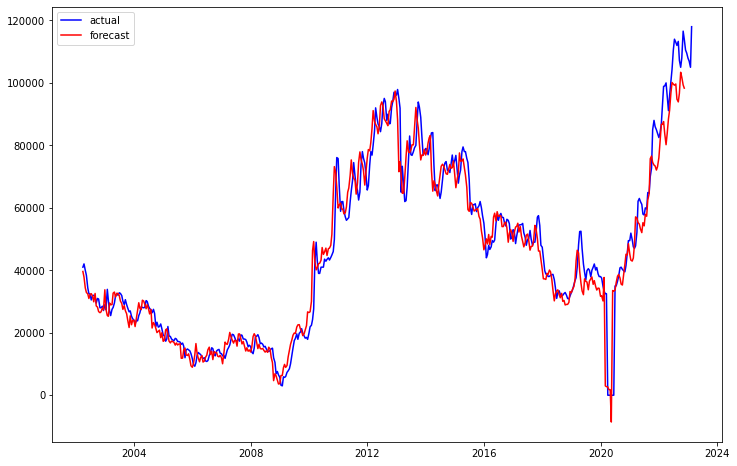

In [286]:
plt.figure(figsize=(12,8))
plt.plot(final_df_e['ds'],final_df_e['y'], color='blue', label = 'actual')
plt.plot(final_df_e['ds'],final_df_e['yhat'], color='red', label = 'forecast')
plt.legend()

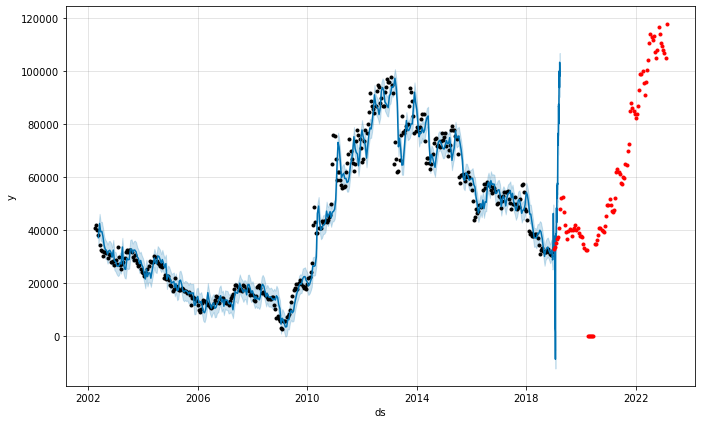

In [287]:
fig_e = m_e.plot(forecast_e)
ax_e = fig_e.gca()
ax_e.plot(test_e["ds"], test_e["y"], 'r.')

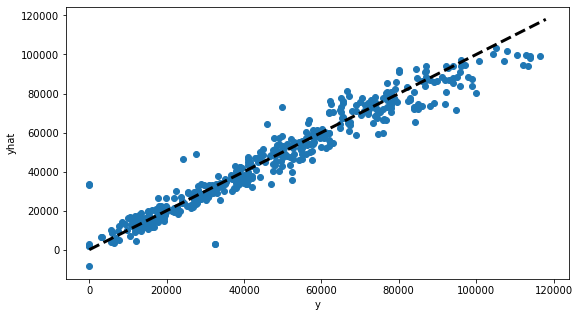

In [288]:
# Plot y against yhat
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
ax.scatter(final_df_e['y'], final_df_e['yhat'])
ax.plot([final_df_e['y'].min(), final_df_e['y'].max()], [final_df_e['y'].min(), final_df_e['y'].max()], 'k--', lw=3)
ax.set_xlabel('y')
ax.set_ylabel('yhat')
plt.show()

### Cat E Remodel - RMSE
---

In [289]:
# Cross validation
df_cv = cross_validation(m_e, initial='3650 days', period='30 days', horizon = '1825 days', parallel="processes")
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-05-01,91454.239801,88763.950515,94410.563135,88990,2012-04-25
1,2012-05-15,88911.698817,86321.583485,91755.003746,86889,2012-04-25
2,2012-06-01,88639.742743,85828.510439,91404.469992,85889,2012-04-25
3,2012-06-15,87809.054663,85015.482442,90622.771450,84389,2012-04-25
4,2012-07-01,86573.552477,83703.893960,89156.544803,86999,2012-04-25


In [290]:
# Model performance metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,181 days,5.038345e+07,7098.130316,4665.146830,0.061416,0.036627,0.057603,0.515873
1,190 days,5.451298e+07,7383.290669,4778.731233,0.063212,0.037416,0.059005,0.511905
2,191 days,5.565802e+07,7460.430452,4846.210314,0.064358,0.038076,0.060024,0.507937
3,192 days,5.343924e+07,7310.214634,4813.232891,0.063602,0.038181,0.059506,0.503968
4,193 days,5.346880e+07,7312.236532,4822.343972,0.063690,0.038181,0.059594,0.501323


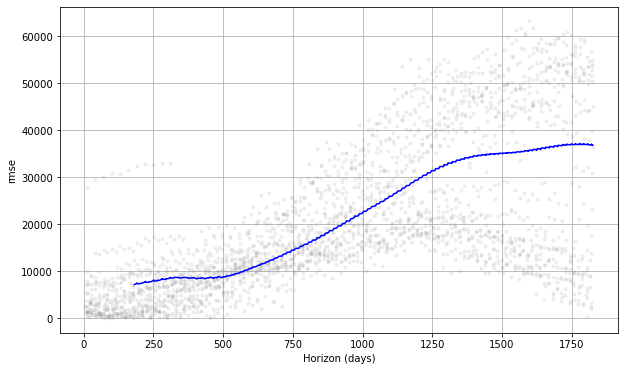

In [291]:
# Visualize the performance metrics
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [292]:
metric_e = forecast_e.set_index('ds')[['yhat']].join(df_e.set_index('ds').y).reset_index()

In [293]:
metric_e.tail()

,ds,yhat,y
494,2019-03-21,96690.858750,NaN
495,2019-03-22,103407.746554,NaN
496,2019-03-23,101820.672014,NaN
497,2019-03-24,99351.361446,NaN
498,2019-03-25,98323.314752,NaN


In [294]:
#drop null as we only want to look at the actual values.
metric_e.dropna(inplace=True)

In [295]:
metric_e.tail()

,ds,yhat,y
429,2019-01-15,31666.168321,33689.0
446,2019-02-01,35570.572699,35310.0
460,2019-02-15,55310.289717,36667.0
474,2019-03-01,73396.715109,37620.0
488,2019-03-15,100126.256857,41000.0


In [296]:
# calculate r2
r2_score(metric_e.y, metric_e.yhat)

0.9160555144852175

In [297]:
# calculate rmse
mean_squared_error(metric_e.y, metric_e.yhat, squared = False)

7306.833007502431

In [298]:
# calculate mape
mean_absolute_percentage_error(metric_e.y, metric_e.yhat)

0.1301208392413263

### Cat E - Base vs Remodel

|                	|          **r2**         	| **RMSE** 	| **MAPE** 	|
|:--------------:	|:-----------------------:	|:--------:	|:--------:	|
| **Base Model** 	|          89.31          |    8,245.02    |    14.13    |
|   **Remodel**  	|          91.61          |    7,306.83    |    13.01    |

### Cat E Remodel - Coefficients

In [299]:
coef = regressor_coefficients(m_e)

In [300]:
coef['abs_coef'] = coef['coef'].apply(lambda x: abs(x))
coef['colors'] = coef['coef'].apply(lambda x: 'green' if x > 0 else 'red')
coef = coef.sort_values('abs_coef', ascending=False)
coef.head(10)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper,abs_coef,colors
9,cat_e_successful_bids_lag,additive,675.957711,6.580885,6.580885,6.580885,6.580885,green
5,cat_a_successful_bids_lag,additive,1470.888060,5.446607,5.446607,5.446607,5.446607,green
2,cat_e_quota,additive,687.216418,-4.465553,-4.465553,-4.465553,4.465553,red
3,total_successful_bids_lag,additive,3855.748756,-2.496798,-2.496798,-2.496798,2.496798,red
6,cat_a_bids_received_lag,additive,2059.116915,-2.472035,-2.472035,-2.472035,2.472035,red
0,total_quota,additive,3918.888060,-2.390753,-2.390753,-2.390753,2.390753,red
4,total_bids_received_lag,additive,5536.922886,2.067994,2.067994,2.067994,2.067994,green
1,cat_a_quota,additive,1482.751244,1.877646,1.877646,1.877646,1.877646,green
16,reg_cat_b_lag,additive,2643.880597,1.395815,1.395815,1.395815,1.395815,green
11,cat_e_quota_premium_lag,additive,42288.161692,0.851766,0.851766,0.851766,0.851766,green


Text(0.5, 0, 'Regressor')

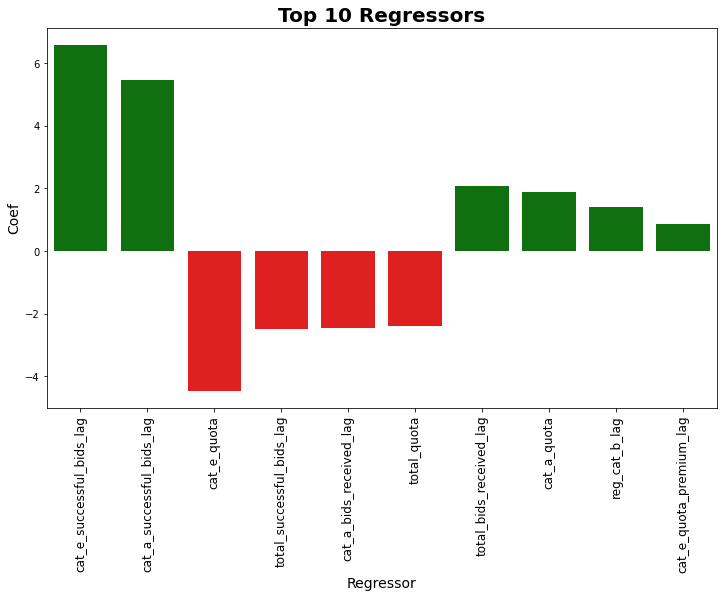

In [301]:
# plot coefficients of features
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x='regressor',
            y='coef',
            data=coef.head(10),
           palette=coef.head(10)['colors'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=12)
ax.set_title('Top 10 Regressors', fontsize=20, fontweight='bold')
ax.set_ylabel('Coef', fontsize=14)
ax.set_xlabel('Regressor', fontsize=14)

### Cat E - Summary

1) Usually people will use Cat E COE to register for Cat B vehicles, hence similar trend to Cat B COE is observed.<br>
When the number of successful bids for both Cat A and Cat E are higher, Cat E COE premium tend to be higher. Higher number of successful bids for both Cat A and Cat E could mean a general trend where there are more cars sales and therefore higher demand for COE.

2) When the number of Cat E quota is lower, Cat E COE premium tends to be higher.

3) When the number of total bids received is higher in the previous round of bidding, Cat E COE premium is expected to be higher.

4) When there are more registration of Cat B vehicles, COE E premium is higher.

## Conclusion
---

|                      | **r2** | **RMSE** | **MAPE** |
|:--------------------:|:------:|:--------:|:--------:|
| **Cat A Base Model** |  91.31 | 6,264.72 |   18.21  |
| **Cat A Remodel**    |  94.93 | 4,785.22 |   14.22  |
| **Cat B Base Model** |  89.48 | 8,130.42 |   20.87  |
| **Cat B Remodel**    |  92.59 | 6,823.10 |   18.68  |
| **Cat C Base Model** |  89.31 | 8,245.02 |   14.13  |
| **Cat C Remodel**    |  91.61 | 7,306.83 |   13.01  |

1) The models provided very good accuracy score, though the RMSE and MAPE can be improved.

2) The models do not seem to work as well from year 2022 onward, when there is a lot of global factors impacting Singapore's economy.